# Data Preparation

Data preparation plan:

1. Load the transaction data
2. Merge the transaction data with the fleet register datasets
3. Clean the columns and remove all unnecessary transactions
4. Add the coordinates of the transactions based on the merchant name
5. Add the true fuel prices to the transactions
6. Create a second dataset with the total fuel consumption per vehicle based on the tracking dataset

# 1. Load the transaction data

In [1]:
import pandas as pd
import openpyxl
import os

In [2]:
# Load in the transaction dataset
raw_trans = pd.read_csv(os.path.join("..", "data", "2021 Monthly Full Transactions.csv"))

In [3]:
# Check dataset size
raw_trans.shape

(207702, 8)

In [4]:
# Check the data structure
raw_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207702 entries, 0 to 207701
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Transaction Date    207693 non-null  object 
 1   REG_NUM             207693 non-null  object 
 2   Merchant Name       207675 non-null  object 
 3   Purchase Category   207693 non-null  object 
 4   No. of Litres       207693 non-null  float64
 5   Transaction Amount  207702 non-null  float64
 6   Make                207693 non-null  object 
 7   Model               207693 non-null  object 
dtypes: float64(2), object(6)
memory usage: 12.7+ MB


# 2. Merge the transaction data with the fleet register datasets

## 2.1 Load the fleet register datasets

In [5]:
full_register = pd.read_csv(os.path.join("..", "data", "full_fleet_register.csv"), sep=';')

colnames = ['NEW REG  NO.', 'VEHICLE MAKE', 'MODEL DERIVATIVE', 'DEPARTMENT', 'RATE CARD CATEGORY']

full_register = full_register[colnames]

full_register = full_register.rename(columns={'NEW REG  NO.': 'Reg No'})

In [6]:
white = pd.read_csv(os.path.join("..", "data", "white fleet data.csv"), sep=';')

colnames = ['Reg No', 'Old Reg', 'Site', 'District']

white = white[colnames]

white = white.rename(columns={'Rental ': 'Rental'})

In [8]:
ems = pd.read_csv(os.path.join("..", "data", "EMS Fleet Data Sep 2022.csv"), sep=';')

colnames = ['Reg No', 'Old Reg', 'Site', 'District']

# Select columns
ems = ems[colnames]

# Rename the rental column from " Rental " to "Rental"
ems = ems.rename(columns={' Rental ': 'Rental'})

## 2.2 Combine the white and ems fleet register datasets

In [9]:
white_ems = pd.concat([white, ems], ignore_index=True)

In [10]:
cols = ['Site', 'District']

# Reshaping the DataFrame for 'New' IDs
new_regs = white_ems.melt(id_vars=cols, 
                  value_vars=['Reg No'], 
                  var_name='Type', 
                  value_name='Reg').drop(columns=['Type'])

# Reshaping the DataFrame for 'Old' IDs
old_regs = white_ems.melt(id_vars=cols, 
                  value_vars=['Old Reg'], 
                  var_name='Type', 
                  value_name='Reg').drop(columns=['Type'])

# Concatenating the two DataFrames
reshaped_white_ems = pd.concat([new_regs, old_regs]).sort_values(by='Reg').reset_index(drop=True)

## 2.3 Merge the datasets

In [20]:
raw_data = pd.merge(raw_trans, full_register, how='left', left_on='REG_NUM', right_on='Reg No')
raw_data = raw_data.drop(columns=['Reg No'])

In [21]:
# left join df and white on REG_NUM and Reg No
raw_data = pd.merge(raw_data, reshaped_white_ems, how='left', left_on='REG_NUM', right_on='Reg')

# drop the Reg column
raw_data = raw_data.drop(columns=['Reg'])

# check for null values
print(raw_data.isnull().sum())

Transaction Date       1674
REG_NUM                1674
Merchant Name          1692
Purchase Category      1674
No. of Litres          1674
Transaction Amount        0
Make                   1674
Model                  1674
VEHICLE MAKE          27750
MODEL DERIVATIVE      27631
DEPARTMENT            27631
RATE CARD CATEGORY    27631
Site                  94759
District              95109
dtype: int64


## 3. Clean the columns and remove all unnecessary transactions

## 3.1 Find all the vehicles in the transaction dataset that are not in the fleet register dataset

In [23]:
# Remove all rows with null where the "MODEL DERIVATIVE" is null - vehicles under invstigation and not included in analysis
clean_data = raw_data.dropna(subset=['MODEL DERIVATIVE'])

# check for null values
print(clean_data.isnull().sum())

Transaction Date          0
REG_NUM                   0
Merchant Name            17
Purchase Category         0
No. of Litres             0
Transaction Amount        0
Make                      0
Model                     0
VEHICLE MAKE            119
MODEL DERIVATIVE          0
DEPARTMENT                0
RATE CARD CATEGORY        0
Site                  74969
District              75094
dtype: int64


In [24]:
clean_data.shape

(182075, 14)

## 3.2 Vehicle make

In [26]:
# Check which "VEHICLE MAKE" and "MODEL DERIVATIVE" are null
clean_data[clean_data['VEHICLE MAKE'].isnull()]

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,VEHICLE MAKE,MODEL DERIVATIVE,DEPARTMENT,RATE CARD CATEGORY,Site,District
7604,2021-04-14,GGF298EC,TOTAL SAVOY MTHATHA,FUEL,300.00,4953.00,MAN,26.423 DFTF T/T C/C,NaN,M.A.N 27.463 DFTF INTARDER,TRANSPORT,MANAGED MAINTENANCE,NaN,NaN
25827,2021-05-06,GGF298EC,SASOL SUTHERLAND,FUEL,198.84,3241.25,MAN,26.423 DFTF T/T C/C,NaN,M.A.N 27.463 DFTF INTARDER,TRANSPORT,MANAGED MAINTENANCE,NaN,NaN
78467,2021-07-21,GGW518EC,AFRICAN FRONT T/A CP MOTORS,FUEL,500.00,8435.00,TRAILER,1 AXLE TANKER,NaN,SEMI TRL - 1 AXLE TANKER,RURAL DEVELOPMENT AND AGRARIAN REFORM,MANAGED MAINTENANCE,NaN,NaN
78468,2021-07-27,GGW518EC,AFRICAN FRONT T/A CP MOTORS,FUEL,533.40,9000.00,TRAILER,1 AXLE TANKER,NaN,SEMI TRL - 1 AXLE TANKER,RURAL DEVELOPMENT AND AGRARIAN REFORM,MANAGED MAINTENANCE,NaN,NaN
100415,2021-08-03,GGW518EC,AFRICAN FRONT T/A CP MOTORS,FUEL,500.00,8435.00,TRAILER,1 AXLE TANKER,NaN,SEMI TRL - 1 AXLE TANKER,RURAL DEVELOPMENT AND AGRARIAN REFORM,MANAGED MAINTENANCE,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206464,2022-01-27,GGW518EC,TOTAL BIZANA,FUEL,500.00,9580.00,TRAILER,1 AXLE TANKER,NaN,SEMI TRL - 1 AXLE TANKER,RURAL DEVELOPMENT AND AGRARIAN REFORM,MANAGED MAINTENANCE,NaN,NaN
206465,2022-01-27,GGW518EC,TOTAL BIZANA,FUEL,950.00,18202.00,TRAILER,1 AXLE TANKER,NaN,SEMI TRL - 1 AXLE TANKER,RURAL DEVELOPMENT AND AGRARIAN REFORM,MANAGED MAINTENANCE,NaN,NaN
206466,2022-01-14,GGW594EC,BISHO MOTORS,FUEL,400.01,7580.20,TANKER,DIESEL,NaN,2013 TANKER DIESEL,RURAL DEVELOPMENT AND AGRARIAN REFORM,MANAGED MAINTENANCE,NaN,NaN
206467,2022-01-04,GGW595EC,EDWARDS GARAGE & SERVICE STATION,FUEL,1000.00,19190.00,TANKER,DIESEL,NaN,2013 TANKER DIESEL,RURAL DEVELOPMENT AND AGRARIAN REFORM,MANAGED MAINTENANCE,NaN,NaN


In [28]:
# Remove the trucks and tankers from the dataset
clean_data = clean_data[~clean_data['VEHICLE MAKE'].isnull()]

# check for null values
print(clean_data.isnull().sum())

Transaction Date          0
REG_NUM                   0
Merchant Name            17
Purchase Category         0
No. of Litres             0
Transaction Amount        0
Make                      0
Model                     0
VEHICLE MAKE              0
MODEL DERIVATIVE          0
DEPARTMENT                0
RATE CARD CATEGORY        0
Site                  74850
District              74975
dtype: int64


In [29]:
# Check the unique VEHICLE MAKE values
clean_data['VEHICLE MAKE'].unique()

array(['ISUZU', 'VOLKSWAGEN', 'HINO', 'TOYOTA', 'NISSAN', 'UD TRUCKS',
       'FORD', 'HYUNDAI', 'MAHINDRA', 'MERCEDES-BENZ', 'AUDI', 'Ford',
       'BMW', 'CHEVROLET', 'Nissan ', 'OPEL', 'FIAT', 'ISUZU ', 'MASSEY',
       'JEEP', 'TATA', 'MITSUBISHI FUSO', 'IVECO', 'LANDROVER',
       'ROSENBAUER', 'NISSAN DIESEL'], dtype=object)

In [30]:
# Create a list of makes to check
makes_to_check = ['HINO', 'UD TRUCKS', 'IVECO', 'MITSUBISHI', 'TATA', 'NISSAN', 'ROSENBAUER', 'MITSUBISHI FUSO']

# For each of the makes to remove, display the unique models
pd.DataFrame(clean_data[clean_data['VEHICLE MAKE'].isin(makes_to_check)].groupby('VEHICLE MAKE')['MODEL DERIVATIVE'].unique())

,MODEL DERIVATIVE
VEHICLE MAKE,
HINO,"[HINO 300 814 LWB, HINO 300 915 LWB (BA3) , HI..."
IVECO,"[IVECO 35S12V12 F/C P/V, IVECO 50C15V15 F/C P/..."
MITSUBISHI FUSO,"[FUSO CANTER FG6-136 SWA F/C C/, MITSUBISHI CA..."
NISSAN,"[NISSAN HARDBODY NP300 2.5 TDI, NISSAN 2.5D SE..."
ROSENBAUER,[PANTHER 6X6 CA5 36.710RHD FIRE ENGINE]
TATA,"[TATA INDICA 1.4 DLS, TATA INDICA 1.4 LSI]"
UD TRUCKS,"[UD CWE330 (E22) MIX BASIC 250H, UD CWE330(E22..."


In [31]:
makes_to_remove = ['IVECO', 'MITSUBISHI FUSO', 'ROSENBAUER', 'UD TRUCKS', 'HINO']

# Remove all of the makes to remove
clean_data = clean_data[~clean_data['VEHICLE MAKE'].isin(makes_to_remove)]

In [32]:
# Display all unique model derivatives
clean_data['MODEL DERIVATIVE'].unique()

array(['D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER',
       'D-MAX 250 HO 4X4 CREW CAB HI-RIDER',
       'VW Crafter 50 2.0 TDI 120 KW XLWB 23S',
       'Hilux DC 2.4GD6 4X4 SRX MT', 'Hilux DC 2.4GD6 RB SRX MT',
       'D-MAX 300 4X4 REGULAR CAB LX',
       'D-MAX 250C REGULAR CAB  FLEETSIDE  REGUL',
       'Isuzu D-Max 250 HO 4X4 Regular Cab Hi-Rider Ambulance',
       '250 D/C Hi-Ride GEN 6', 'TOYOTA QUANTUM 2.7 14 SEAT',
       'TOYOTA QUANTUM 2.5 D-4D SESFIK', 'VW Golf & GTI 2.0 DSG 169 KW',
       'VW POLO VIVO 1.6 SEDAN', 'VW Amarok 2.0 Trendline - ACD7 D/C',
       'Amarok 2.0 Bi Tdi 132 kw Auto Highline 4 motion DC',
       'VW Crafter Panel van Ambulance',
       'VW Crafter 50 2.0 TDI XLWB Ambulance',
       'VW CRAFTER 50 2.0 BITDI HR 120', 'NISSAN HARDBODY NP300 2.5 TDI',
       'NISSAN 2.5D SE+SC 4X4 ABS', 'NISSAN HARDBODY NP300 2.5TDI H',
       'NISSAN 2.4 DC 4X4 HR+ABS', 'NISSAN HARDBODY NP300 2.4I HI-',
       'Nissan K36 NP300 2.4 Hi Rider D/C (Response)',
       'NISSAN N

In [34]:
clean_data.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,VEHICLE MAKE,MODEL DERIVATIVE,DEPARTMENT,RATE CARD CATEGORY,Site,District
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,FUEL,43.06,695.45,ISUZU,DMAX 250 HO DC HR 4X,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,libode,OR Tambo
1,2021-04-01,GGA345EC,SB DELTA,FUEL,31.02,478.17,ISUZU,DMAX 250 HO DC HR 4X,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,JANSENVILLE,Sarah Baartman
2,2021-04-01,GGA345EC,SB DELTA,FUEL,58.95,908.52,ISUZU,DMAX 250 HO DC HR 4X,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,JANSENVILLE,Sarah Baartman
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,58.61,963.66,ISUZU,DMAX 250 HO DC HR 4X,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,ALIWAL NORTH,Alfred Nzo
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,60.02,986.76,ISUZU,DMAX 250 HO DC HR 4X,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,ALIWAL NORTH,Alfred Nzo


In [40]:
# Remove the make and model columns
clean_data = clean_data.drop(columns=['Make', 'Model'])

## 3.2 Purchase Category

In [35]:
# Remove all non-fuel transactions
clean_data = clean_data[clean_data['Purchase Category'] == 'FUEL']

In [36]:
clean_data.shape

(178355, 14)

In [50]:
# Remove the purchase category column
clean_data = clean_data.drop(columns=['Purchase Category'])

## 3.3 Merchant Names

In [37]:
from fuzzywuzzy import process
import pandas as pd

def find_similar_names(name, names, threshold=95):
    """
    Finds similar names in a list of names.
    
    :param name: The name to find similarities to.
    :param names: The list of names to search in.
    :param threshold: The similarity threshold (0-100). Names with a similarity score above this threshold will be considered similar.
    :return: A list of similar names.
    """
    similar_names = process.extractBests(name, names, score_cutoff=threshold)
    # Filter out exact matches (similarity score of 100)
    return [sim_name for sim_name, score in similar_names if score < 100]

def consolidate_names(names_dict):
    """
    Consolidates similar names into a single representative name.

    :param names_dict: A dictionary where keys are original names and values are lists of similar names.
    :return: A dictionary mapping each name (including similar ones) to a single representative name.
    """
    consolidated_dict = {}
    for original_name, similar_names in names_dict.items():
        # Include the original name itself in the mapping
        consolidated_dict[original_name] = original_name
        for similar_name in similar_names:
            # Map similar names to the original name
            consolidated_dict[similar_name] = original_name
    return consolidated_dict

def replace_names(df, names_map, var='Merchant Name'):
    """
    Replace names in the dataframe using a mapping dictionary.

    :param df: The DataFrame containing the names.
    :param names_map: A dictionary mapping each name to a representative name.
    :return: DataFrame with replaced names.
    """
    # Replace names in the DataFrame using the mapping
    df[var] = df[var].map(names_map).fillna(df[var])
    return df

In [38]:
# Extract unique merchant names
unique_names = clean_data['Merchant Name'].unique()

# Remove null values
unique_names = unique_names[~pd.isnull(unique_names)]

# Dictionary to hold each name and its similar names
similar_names_dict = {}

# Iterate over each unique name
for name in unique_names:
    # Find similar names
    similar_names = find_similar_names(name, unique_names)
    # Store in the dictionary
    similar_names_dict[name] = similar_names

# Print the results, excluding exact matches
for name, similarities in similar_names_dict.items():
    if similarities:  # Only print if there are non-exact matches
        print(f"{name}: {similarities}")

AMALINDA MOTORS: ['AMALINDA MOTORS CC']
SAFARI MOTORS: ['SHELL SAFARI MOTORS']
SHELL ULTRA CITY (QUEENSTOWN): ['SHELL ULTRA CITY QUEENSTOWN']
TOTAL DEVEREUX: ['TOTAL RA DEVEREUX']
TOTAL RA DEVEREUX: ['TOTAL DEVEREUX']
Q & Q MOTORS MOUNT FRERE: ['MOUNT FRERE MOTORS']
LEO MOTORS KIRKWOOD: ['KIRKWOOD MOTORS KIRKWOOD']
ELLMORES MOTOR SERVICES GRAHAMSTOWN: ['GRAHAMSTOWN MOTOR SERVICES']
GRAHAMSTOWN MOTOR SERVICES: ['ELLMORES MOTOR SERVICES GRAHAMSTOWN']
MOTHERWELL SERVICE STATION: ['MOTHERWELL SERVICE STATION PTY LTD']
BP @ GREENACRES: ['BP GREENACRES']
KIRKWOOD MOTORS KIRKWOOD: ['LEO MOTORS KIRKWOOD']
BLOEMS MOTORS: ['BLOMS MOTORS']
BELL MOTORS QUEENSTOWN: ['BELLS MOTORS QUEENSTOWN']
MOUNT FRERE MOTORS: ['Q & Q MOTORS MOUNT FRERE']
HADAF VULSTASIE WEST: ['HADAF VULSTASIE EAST']
MOTHERWELL SERVICE STATION PTY LTD: ['MOTHERWELL SERVICE STATION']
SHELL ULTRA CITY QUEENSTOWN: ['SHELL ULTRA CITY (QUEENSTOWN)']
AMALINDA MOTORS CC: ['AMALINDA MOTORS']
HADAF VULSTASIE EAST: ['HADAF VULSTASIE WEST'

In [39]:
# Consolidate similar names into a single representative name for each group
names_map = consolidate_names(similar_names_dict)

# Replace names in the DataFrame
clean_data = replace_names(clean_data, names_map)

# View the replaced DataFrame
clean_data.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,VEHICLE MAKE,MODEL DERIVATIVE,DEPARTMENT,RATE CARD CATEGORY,Site,District
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,FUEL,43.06,695.45,ISUZU,DMAX 250 HO DC HR 4X,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,libode,OR Tambo
1,2021-04-01,GGA345EC,SB DELTA,FUEL,31.02,478.17,ISUZU,DMAX 250 HO DC HR 4X,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,JANSENVILLE,Sarah Baartman
2,2021-04-01,GGA345EC,SB DELTA,FUEL,58.95,908.52,ISUZU,DMAX 250 HO DC HR 4X,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,JANSENVILLE,Sarah Baartman
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,58.61,963.66,ISUZU,DMAX 250 HO DC HR 4X,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,ALIWAL NORTH,Alfred Nzo
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,60.02,986.76,ISUZU,DMAX 250 HO DC HR 4X,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,ALIWAL NORTH,Alfred Nzo


## 3.4 Transaction Amount

In [43]:
# Check for negative transaction amounts - check these for later
clean_data[clean_data['Transaction Amount'] < 0]

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,VEHICLE MAKE,MODEL DERIVATIVE,DEPARTMENT,RATE CARD CATEGORY,Site,District
219,2021-04-01,GGZ844EC,NaN,FUEL,0.0,-798.20,TOYOTA,TOYOTA QUANTUM 2.5 D-4D SESFIK,HEALTH,CATEGORY 15: Minibus 14-16 seater,Raymond Mhlaba LSA Office Admin *P,Amathole
967,2021-04-04,GGA416EC,NaN,FUEL,0.0,-656.24,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,GFMS RENTAL DESK,CATEGORY 8: LDV Ambulance,NaN,NaN
2920,2021-04-07,GGV361EC,NaN,FUEL,0.0,-1114.23,FORD,FORD RANGER 2.2TDCI XL P/U D/C,HEALTH,CATEGORY 13: LDV 4x4 D/Cab,Dir: HIV/AIDS & STD MANGT *P,Alfred Nzo
7373,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-10006.90,ISUZU,KB 250C REGULAR CAB FLEETSIDE,HEALTH,CATEGORY 5: LDV 4x2 1 ton,St Elizabeth Hospital *P,OR Tambo
7374,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-1006.90,ISUZU,KB 250C REGULAR CAB FLEETSIDE,HEALTH,CATEGORY 5: LDV 4x2 1 ton,St Elizabeth Hospital *P,OR Tambo
7375,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-1006.90,ISUZU,KB 250C REGULAR CAB FLEETSIDE,HEALTH,CATEGORY 5: LDV 4x2 1 ton,St Elizabeth Hospital *P,OR Tambo
9579,2021-04-16,GGA337EC,NaN,FUEL,0.0,-590.35,VOLKSWAGEN,VW Crafter Panel van Ambulance,EMERGENCY MEDICAL SERVICES,CATEGORY 18: Ambulances Large p/van,CATHCART,Amathole


## 3.5 Department

In [46]:
# Check for all unique Department values
clean_data['DEPARTMENT'].unique()

array(['EMERGENCY MEDICAL SERVICES', 'HEALTH', 'GFMS RENTAL DESK',
       'TRANSPORT', 'PUBLIC WORKS & INFRASTRUCTURE', 'SOCIAL DEVELOPMENT',
       'COOPERATIVE GOVERNANCE AND TRADITIONAL AFFAIRS',
       'HUMAN SETTLEMENTS', 'GFMS POOL', 'EDUCATION',
       'PROVINCIAL TREASURY', 'RURAL DEVELOPMENT AND AGRARIAN REFORM',
       'ECONOMIC DEVELOPMENT AND ENVIRONMENTAL AFFAIRS',
       'OFFICE OF THE PREMIER', 'SPORTS, RECREATION, ARTS AND CULTURE',
       'COMMUNITY SAFETY'], dtype=object)

In [45]:
# Trim the white space from the end of the Department values
clean_data['DEPARTMENT'] = clean_data['DEPARTMENT'].str.strip()

## 3.6 Rate Card Category

In [47]:
# Display all unique rate card categories
clean_data['RATE CARD CATEGORY'].unique()

array(['CATEGORY 8: LDV Ambulance', 'CATEGORY 33: LDV D/cab Response',
       'CATEGORY 29: Bus 20-23 seater', 'CATEGORY 13: LDV 4x4 D/Cab',
       'CATEGORY 6: LDV 4x2 D/Cab', 'CATEGORY 10: LDV Rescue',
       'CATEGORY 5: LDV 4x2 1 ton ', 'MANAGED MAINTENANCE',
       'CATEGORY 15: Minibus 14-16 seater',
       'CATEGORY 2: Sedan Traffic 1400-1600cc',
       'CATEGORY 1: Sedan 1400-1600cc',
       'CATEGORY 18: Ambulances Large p/van',
       'CATEGORY 46: 14-16 Seater Patient Transport',
       'CATEGORY 32: LDV Heavy Rescue',
       'CATEGORY 11: LDV 4x4 1 ton light', 'CATEGORY 34: LDV Traffic',
       'CATEGORY 38: LDV Mortuary-Hydraulic',
       'CATEGORY 30: Bus 32-35 seater', 'CATEGORY 9: LDV Clinic',
       'CATEGORY 12: LDV 4x4 1 ton heavy',
       'CATEGORY 17: Ambulances  standard p/van',
       'CATEGORY 7: LDV Mortuary', 'CATEGORY 19: Truck 3.5 ton dropside',
       'CATEGORY 20: Truck 4 Ton dropside',
       'CATEGORY 27: Truck 4 Ton Van body',
       'CATEGORY 28: Truck

In [48]:
# Check how many transactions were for the 'MANAGED MAINTENANCE' rate card category
clean_data[clean_data['RATE CARD CATEGORY'] == 'MANAGED MAINTENANCE'].shape

(20582, 12)

In [49]:
# Select a few random transactions for the managed maintenance rate card category
clean_data[clean_data['RATE CARD CATEGORY'] == 'MANAGED MAINTENANCE'].sample(10)

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,VEHICLE MAKE,MODEL DERIVATIVE,DEPARTMENT,RATE CARD CATEGORY,Site,District
39059,2021-05-05,GGZ596EC,MOUNT FRERE MOTORS,FUEL,40.87,678.60,FORD,FORD RANGER 2.2TDCI L/R P/U S/,EDUCATION,MANAGED MAINTENANCE,NaN,NaN
83466,2021-07-21,JHP483EC,MKT CONVENIENCE CENTRE,FUEL,52.44,866.85,TOYOTA,TOYOTA HILUX 2.4 GD-6 SR 4X4,COOPERATIVE GOVERNANCE AND TRADITIONAL AFFAIRS,MANAGED MAINTENANCE,NaN,NaN
2863,2021-04-07,GGF438EC,MASEPE MOTORS CC,FUEL,52.98,839.75,FORD,FORD RANGER 2.2TDCI P/U D/C,EDUCATION,MANAGED MAINTENANCE,NaN,NaN
56651,2021-05-31,GGT533EC,KAAP AGRI ADDO,FUEL,60.00,997.20,NISSAN,NISSAN HARDBODY 2000I SWB,HEALTH,MANAGED MAINTENANCE,NaN,NaN
188782,2021-12-22,GGX432EC,TOTAL MDANTSANE T/A FIREFLY INVESTMENTS,FUEL,55.00,1047.75,VOLKSWAGEN,VW JETTA VI 1.6 TDI COMFORT,TRANSPORT,MANAGED MAINTENANCE,NaN,NaN
198247,2022-01-17,GGF462EC,KU BHA SERVICE STATI,FUEL,72.83,1403.45,VOLKSWAGEN,VW Amarok 2.0 Trendline - ACD7 D/C,TRANSPORT,MANAGED MAINTENANCE,NaN,NaN
47823,2021-06-07,GGF412EC,ALIWAL AUTO VULSTASIE,FUEL,50.86,866.20,VOLKSWAGEN,VW Golf & GTI 2.0 DSG 169 KW,TRANSPORT,MANAGED MAINTENANCE,NaN,NaN
58450,2021-05-31,GGY783EC,MOUNT AYLIFF SERVICE STATION,FUEL,64.34,1034.58,Nissan,NISSAN HARDBODY 2.5 TDI HIRIDE,EDUCATION,MANAGED MAINTENANCE,NaN,NaN
10761,2021-04-18,GGG246EC,MASEPE MOTORS CC,FUEL,44.12,699.30,Ford,Ranger 2019 5MY D/C XL 2.2D 118KW 6AT 4X2HR,RURAL DEVELOPMENT AND AGRARIAN REFORM,MANAGED MAINTENANCE,NaN,NaN
92364,2021-08-10,GGF785EC,STERKSPRUIT GARAGE,FUEL,69.90,1237.23,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,HEALTH,MANAGED MAINTENANCE,NaN,NaN


Most seem to be fine and operating, although the fleet register dataset is from a later date and the vehicles could have been placed in managed maintenance by that point.

## 3.7 District

In [51]:
# Display all unique District values
clean_data['District'].unique()

array(['OR Tambo', 'Sarah Baartman', 'Alfred Nzo', 'Joe Gqabi',
       'Amathole', 'Buffalo City', 'Chris Hani', nan,
       'Nelson Mandela Metro', 'Head Office', 'Nelson Mandela',
       'EMS College'], dtype=object)

In [53]:
# Check the distribution of the District variable
clean_data['District'].value_counts(dropna=False)

District
NaN                     74191
Sarah Baartman          17790
OR Tambo                17319
Chris Hani              14075
Amathole                13034
Joe Gqabi               12341
Alfred Nzo              11724
Buffalo City             8917
Nelson Mandela           4602
Nelson Mandela Metro     2551
Head Office              1438
EMS College               373
Name: count, dtype: int64

In [54]:
# Change the NA district to "UNKNOWN"
clean_data['District'] = clean_data['District'].fillna('UNKNOWN')

In [55]:
# Check the distribution of the District variable
clean_data['District'].value_counts(dropna=False)

District
UNKNOWN                 74191
Sarah Baartman          17790
OR Tambo                17319
Chris Hani              14075
Amathole                13034
Joe Gqabi               12341
Alfred Nzo              11724
Buffalo City             8917
Nelson Mandela           4602
Nelson Mandela Metro     2551
Head Office              1438
EMS College               373
Name: count, dtype: int64

## 3.8 Site

In [56]:
# Check the distribution of the Site variable
clean_data['Site'].value_counts(dropna=False)

Site
NaN                                    74067
Port Elizabeth                          3288
East London                             2897
EAST LONDON                             2794
MTHATHA                                 2794
                                       ...  
Sundays Valley Hospital *P                12
PE Medical Depot *P                        9
Forensic S Port Alfred *P                  7
NQAMAKWE                                   6
Lilitha Nursing Col - All Saints *P        1
Name: count, Length: 321, dtype: int64

In [57]:
# Change the NA site values to "UNKNOWN"
clean_data['Site'] = clean_data['Site'].fillna('UNKNOWN')

In [58]:
# Convert all sites to upper case
clean_data['Site'] = clean_data['Site'].str.upper()

In [59]:
# Extract unique site names
unique_names = clean_data['Site'].unique()

# Remove null values
unique_names = unique_names[~pd.isnull(unique_names)]

# Dictionary to hold each name and its similar names
similar_names_dict = {}

# Iterate over each unique name
for name in unique_names:
    # Find similar names
    similar_names = find_similar_names(name, unique_names)
    # Store in the dictionary
    similar_names_dict[name] = similar_names

# Print the results, excluding exact matches
for name, similarities in similar_names_dict.items():
    if similarities:  # Only print if there are non-exact matches
        print(f"{name}: {similarities}")

ALIWAL NORTH: ['ALWAL NORTH']
NTABANKULU: ['TABANKULU']
GRAAFF REINET: ['GRAAF REINET', 'GRAAF-REINET']
DIR: JOE GQABI *P: ['DIR: JOE GQABI']
BARKLYEAST: ['BARKLY EAST']
LADY GREY HOSPITAL *P: ['GREY HOSPITAL *P']
GRAAF REINET: ['GRAAFF REINET']
BARKLY EAST: ['BARKLYEAST']
GLEN GREY HOSPITAL *P: ['GREY HOSPITAL *P']
LILITHA NURSING COL - QUEENSTOWN (STERKSPRUIT) *P: ['LILITHA NURSING COL - QUEENSTOWN *P']
LILITHA NURSING COL - QUEENSTOWN *P: ['LILITHA NURSING COL - QUEENSTOWN (STERKSPRUIT) *P']
TABANKULU: ['NTABANKULU']
GREY HOSPITAL *P: ['LADY GREY HOSPITAL *P', 'GLEN GREY HOSPITAL *P']
FORENSIC BUTTERWORTH *P: ['FORENSIC S BUTTERWORTH *P']
DIR: JOE GQABI: ['DIR: JOE GQABI *P']
ALWAL NORTH: ['ALIWAL NORTH']
FORENSIC S BUTTERWORTH *P: ['FORENSIC BUTTERWORTH *P']
GRAAF-REINET: ['GRAAFF REINET']


In [60]:
# Consolidate similar names into a single representative name for each group
names_map = consolidate_names(similar_names_dict)

# Replace names in the DataFrame
clean_data = replace_names(clean_data, names_map, var='Site')

# View the replaced DataFrame
clean_data.head()

,Transaction Date,REG_NUM,Merchant Name,No. of Litres,Transaction Amount,VEHICLE MAKE,MODEL DERIVATIVE,DEPARTMENT,RATE CARD CATEGORY,Site,District
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,43.06,695.45,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,LIBODE,OR Tambo
1,2021-04-01,GGA345EC,SB DELTA,31.02,478.17,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,JANSENVILLE,Sarah Baartman
2,2021-04-01,GGA345EC,SB DELTA,58.95,908.52,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,JANSENVILLE,Sarah Baartman
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,58.61,963.66,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,ALWAL NORTH,Alfred Nzo
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,60.02,986.76,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,ALWAL NORTH,Alfred Nzo


In [61]:
# Convert the names to camel case
clean_data['Site'] = clean_data['Site'].str.title()
clean_data.head()

,Transaction Date,REG_NUM,Merchant Name,No. of Litres,Transaction Amount,VEHICLE MAKE,MODEL DERIVATIVE,DEPARTMENT,RATE CARD CATEGORY,Site,District
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,43.06,695.45,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,Libode,OR Tambo
1,2021-04-01,GGA345EC,SB DELTA,31.02,478.17,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,Jansenville,Sarah Baartman
2,2021-04-01,GGA345EC,SB DELTA,58.95,908.52,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,Jansenville,Sarah Baartman
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,58.61,963.66,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,Alwal North,Alfred Nzo
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,60.02,986.76,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,Alwal North,Alfred Nzo


In [64]:
def replace_site_names(df, site_replacements):
    """
    Replace site names in the dataframe based on certain patterns.

    :param df: DataFrame containing the 'Site' column.
    :return: DataFrame with updated 'Site' column.
    """

    # Temporarily fill NaN values with an empty string for comparison
    df['Site'] = df['Site'].fillna('')

    for old_site, new_site in site_replacements.items():
        # Check that the values are not null
        if not pd.isnull(old_site) and not pd.isnull(new_site):
            # Using str.startswith() to match the beginning of the string
            df.loc[df['Site'].str.startswith(old_site), 'Site'] = new_site

    # Revert the empty strings back to NaN
    df['Site'].replace('', pd.NA, inplace=True)

    return df

In [65]:
site_replacements = {
    '0': 'UNKNOWN',
    '43501': 'UNKNOWN'
}

# Apply the function to replace model names
clean_data = replace_site_names(clean_data, site_replacements)

# Example of the replaced DataFrame
clean_data.head()

,Transaction Date,REG_NUM,Merchant Name,No. of Litres,Transaction Amount,VEHICLE MAKE,MODEL DERIVATIVE,DEPARTMENT,RATE CARD CATEGORY,Site,District
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,43.06,695.45,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,Libode,OR Tambo
1,2021-04-01,GGA345EC,SB DELTA,31.02,478.17,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,Jansenville,Sarah Baartman
2,2021-04-01,GGA345EC,SB DELTA,58.95,908.52,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,Jansenville,Sarah Baartman
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,58.61,963.66,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,Alwal North,Alfred Nzo
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,60.02,986.76,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance,Alwal North,Alfred Nzo


In [67]:
# Check the final dimensions of the dataset
clean_data.shape

(178355, 11)

In [66]:
# Save the cleaned dataset to a new CSV file
clean_data.to_csv(os.path.join("..", "data", "cleaned_data.csv"), index=False)

# 4. Add the coordinates of the transactions based on the merchant name

In [68]:
# Read in the clean dataset 
clean_data = pd.read_csv(os.path.join("..", "data", "cleaned_data.csv"))

In [ ]:
from geopy.geocoders import GoogleV3
import configparser
import pandas as pd

# Read API key from config file
config = configparser.ConfigParser()
config.read('../config.ini')
api_key = config['DEFAULT']['GOOGLE_API_KEY']

# Create a geocoder object
geolocator = GoogleV3(api_key=api_key)

# Function to get coordinates
def get_coordinates(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
    except Exception as e:
        print(f"Error occurred: {e}")
    return None, None

# Caching the geocoded results
cached_coordinates = {}

# Iterate over unique sites
for site in clean_data['Site'].unique():
    address = f"{site}, Eastern Cape, South Africa"
    if address not in cached_coordinates:
        cached_coordinates[address] = get_coordinates(address)

# Apply cached coordinates to the DataFrame
clean_data['Site Lat'] = clean_data['Site'].map(lambda x: cached_coordinates[f"{x}, Eastern Cape, South Africa"][0])
clean_data['Site Long'] = clean_data['Site'].map(lambda x: cached_coordinates[f"{x}, Eastern Cape, South Africa"][1])

## Transaction Date

In [5]:
# Convert transaction date to datetime format
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])

In [6]:
# Check the range of the transaction dates
df['Transaction Date'].min(), df['Transaction Date'].max()

(Timestamp('2021-04-01 00:00:00'), Timestamp('2022-01-29 00:00:00'))

## Registration Number

In [7]:
# Check the number of unique registration numbers
df['REG_NUM'].nunique()

4475

In [8]:
# Display the unique registration numbers
df['REG_NUM'].unique()

array(['GGA344EC', 'GGA345EC', 'GGA346EC', ..., 'GGZ979EC', 'JBS257EC',
       'JXL688EC'], dtype=object)

In [9]:
# Check for unique registration numbers shorter than 8 characters
df[df['REG_NUM'].str.len() < 8]['REG_NUM'].nunique()

10

In [10]:
# Check for unique registration numbers shorter than 8 characters
df[df['REG_NUM'].str.len() < 8]['REG_NUM'].unique()

array(['DOT1', 'DOT2', '105', 'DOT20', 'DOT6', 'DOT14', 'DOT15', 'DOT13',
       'GENEDU', 'DOT5'], dtype=object)

In [11]:
# Display the rows with registration numbers shorter than 8 characters (unique reg numbers)
df[df['REG_NUM'].str.len() < 8].drop_duplicates(subset=['REG_NUM'])

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model
20,2021-04-01,DOT1,TOTAL SAVOY MTHATHA,FUEL,36.53,580.10,CATERPILLAR,CATERPILLAR GRADER 1
21,2021-04-01,DOT2,SMITH & WIGGIL-SOUTH QUEENS CONVENIENCE,FUEL,53.46,818.47,CATERPILLAR,CATERPILLAR GRADER 1
981,2021-04-04,105,BEACONHILL SRERVICE STATION,FUEL,42.80,664.75,GENERATOR,GENERATOR DIESEL
2363,2021-04-07,DOT20,SESETI DEALERS PTY LTD /T A SETTLERS,FUEL,19.51,304.82,CATERPILLAR,CATERPILLAR GRADER 1
3302,2021-04-08,DOT6,BONZA BAY CONVENIENCE,FUEL,46.14,743.90,BULK CARD,BULK CARD
5686,2021-04-12,DOT14,JD MOTORS,FUEL,34.58,574.05,BULK CARD,BULK CARD
5687,2021-04-12,DOT15,JD MOTORS,FUEL,77.21,1234.60,BULK CARD,BULK CARD
16547,2021-04-27,DOT13,UBUNTU FUEL STATION,FUEL,56.66,920.85,BULK CARD,BULK CARD
41087,2021-06-11,GENEDU,AIRPORT MOTORS RETAIL CENTRE,FUEL,962.31,14559.81,BULK CARD,BULK CARD
62043,2021-07-07,DOT5,SESETI DEALERS PTY LTD /T A SETTLERS,FUEL,38.03,634.34,BULK CARD,BULK CARD


In [12]:
# Check for null values in the registration number column
df['REG_NUM'].isnull().sum()

9

In [13]:
# Remove the rows where the registration number column is null
df = df[df['REG_NUM'].notnull()]

Seems like there are registration numbers for construction vehicles or equipment as well. Also not sure about the BULK CARD type, but it can probably be included if vehicles used it enough (ie enough transactions with it)

## Merchant

In [14]:
# Check the unique merchant names
df['Merchant Name'].nunique()

1082

In [18]:
# Check how many merchant names are null
df['Merchant Name'].isnull().sum()

18

In [15]:
# Display the null values in the merchant name column
df[df['Merchant Name'].isnull()]


,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model
219,2021-04-01,GGZ844EC,NaN,FUEL,0.0,-798.20,TOYOTA,QUANTUM 2.5D4D 16S
274,2021-04-01,GGF269EC,NaN,FUEL,0.0,-485.96,HYUNDAI,ACCENT 1.6 GLS AT
960,2021-04-04,GGA416EC,NaN,FUEL,0.0,-656.24,ISUZU,DMAX 250 HO DC HR 4X
2907,2021-04-07,GGV361EC,NaN,FUEL,0.0,-1114.23,FORD,RANGER T 7 2.2L TDCI
5603,2021-04-11,GGG195EC,NaN,FUEL,0.0,798.60,VOLKSWAGEN,POLO VIVO 1.6
5636,2021-04-12,GGA346EC,NaN,REPAIRS,0.0,2250.00,ISUZU,DMAX 250 HO DC HR 4X
7352,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-10006.90,ISUZU,KB250DTEQ SAFETY F/S
7353,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-1006.90,ISUZU,KB250DTEQ SAFETY F/S
7354,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-1006.90,ISUZU,KB250DTEQ SAFETY F/S
7783,2021-04-14,GGZ795EC,NaN,FUEL,0.0,945.65,TOYOTA,QUANTUM 2.5D 14SEATE


In [19]:
# Check which values in the merchant name column are not a string
df[~df['Merchant Name'].apply(lambda x: isinstance(x, str))]

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model
219,2021-04-01,GGZ844EC,NaN,FUEL,0.0,-798.20,TOYOTA,QUANTUM 2.5D4D 16S
274,2021-04-01,GGF269EC,NaN,FUEL,0.0,-485.96,HYUNDAI,ACCENT 1.6 GLS AT
960,2021-04-04,GGA416EC,NaN,FUEL,0.0,-656.24,ISUZU,DMAX 250 HO DC HR 4X
2907,2021-04-07,GGV361EC,NaN,FUEL,0.0,-1114.23,FORD,RANGER T 7 2.2L TDCI
5603,2021-04-11,GGG195EC,NaN,FUEL,0.0,798.60,VOLKSWAGEN,POLO VIVO 1.6
5636,2021-04-12,GGA346EC,NaN,REPAIRS,0.0,2250.00,ISUZU,DMAX 250 HO DC HR 4X
7352,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-10006.90,ISUZU,KB250DTEQ SAFETY F/S
7353,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-1006.90,ISUZU,KB250DTEQ SAFETY F/S
7354,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-1006.90,ISUZU,KB250DTEQ SAFETY F/S
7783,2021-04-14,GGZ795EC,NaN,FUEL,0.0,945.65,TOYOTA,QUANTUM 2.5D 14SEATE


In [9]:
from fuzzywuzzy import process
import pandas as pd

def find_similar_names(name, names, threshold=95):
    """
    Finds similar names in a list of names.
    
    :param name: The name to find similarities to.
    :param names: The list of names to search in.
    :param threshold: The similarity threshold (0-100). Names with a similarity score above this threshold will be considered similar.
    :return: A list of similar names.
    """
    similar_names = process.extractBests(name, names, score_cutoff=threshold)
    # Filter out exact matches (similarity score of 100)
    return [sim_name for sim_name, score in similar_names if score < 100]


In [ ]:

# Extract unique merchant names
unique_names = df['Merchant Name'].unique()

# Remove null values
unique_names = unique_names[~pd.isnull(unique_names)]

# Dictionary to hold each name and its similar names
similar_names_dict = {}

# Iterate over each unique name
for name in unique_names:
    # Find similar names
    similar_names = find_similar_names(name, unique_names)
    # Store in the dictionary
    similar_names_dict[name] = similar_names

# Print the results, excluding exact matches
for name, similarities in similar_names_dict.items():
    if similarities:  # Only print if there are non-exact matches
        print(f"{name}: {similarities}")

In [10]:
def consolidate_names(names_dict):
    """
    Consolidates similar names into a single representative name.

    :param names_dict: A dictionary where keys are original names and values are lists of similar names.
    :return: A dictionary mapping each name (including similar ones) to a single representative name.
    """
    consolidated_dict = {}
    for original_name, similar_names in names_dict.items():
        # Include the original name itself in the mapping
        consolidated_dict[original_name] = original_name
        for similar_name in similar_names:
            # Map similar names to the original name
            consolidated_dict[similar_name] = original_name
    return consolidated_dict

def replace_names(df, names_map, var='Merchant Name'):
    """
    Replace names in the dataframe using a mapping dictionary.

    :param df: The DataFrame containing the names.
    :param names_map: A dictionary mapping each name to a representative name.
    :return: DataFrame with replaced names.
    """
    # Replace names in the DataFrame using the mapping
    df[var] = df[var].map(names_map).fillna(df[var])
    return df


In [22]:

# Consolidate similar names into a single representative name for each group
names_map = consolidate_names(similar_names_dict)

# Replace names in the DataFrame
df = replace_names(df, names_map)

# View the replaced DataFrame
df.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,FUEL,43.06,695.45,ISUZU,DMAX 250 HO DC HR 4X
1,2021-04-01,GGA345EC,SB DELTA,FUEL,31.02,478.17,ISUZU,DMAX 250 HO DC HR 4X
2,2021-04-01,GGA345EC,SB DELTA,FUEL,58.95,908.52,ISUZU,DMAX 250 HO DC HR 4X
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,58.61,963.66,ISUZU,DMAX 250 HO DC HR 4X
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,60.02,986.76,ISUZU,DMAX 250 HO DC HR 4X


In [23]:
# Check the number of unique merchant names
df['Merchant Name'].nunique()

1063

In [43]:
# Check the number of null values in the merchant name column
df['Merchant Name'].isnull().sum()

18

In [44]:
# View the null values in the merchant name column
df[df['Merchant Name'].isnull()]

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model
219,2021-04-01,GGZ844EC,NaN,FUEL,0.0,-798.20,TOYOTA,QUANTUM 2.5D4D 16S
274,2021-04-01,GGF269EC,NaN,FUEL,0.0,-485.96,HYUNDAI,ACCENT 1.6 GLS AT
960,2021-04-04,GGA416EC,NaN,FUEL,0.0,-656.24,ISUZU,DMAX 250 HO DC HR 4X
2907,2021-04-07,GGV361EC,NaN,FUEL,0.0,-1114.23,FORD,RANGER T 7 2.2L TDCI
5603,2021-04-11,GGG195EC,NaN,FUEL,0.0,798.60,VOLKSWAGEN,POLO VIVO 1.6
5636,2021-04-12,GGA346EC,NaN,REPAIRS,0.0,2250.00,ISUZU,DMAX 250 HO DC HR 4X
7352,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-10006.90,ISUZU,KB250DTEQ SAFETY F/S
7353,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-1006.90,ISUZU,KB250DTEQ SAFETY F/S
7354,2021-04-13,GGZ971EC,NaN,FUEL,0.0,-1006.90,ISUZU,KB250DTEQ SAFETY F/S
7783,2021-04-14,GGZ795EC,NaN,FUEL,0.0,945.65,TOYOTA,QUANTUM 2.5D 14SEATE


## Purchase Category

In [46]:
# Check the unique purchase categories
df['Purchase Category'].nunique()

10

In [47]:
# View the unique purchase categories
df['Purchase Category'].unique()

array(['FUEL', 'OIL', 'REPAIRS', 'MAJOR MAINTENANCE', 'TYRES', 'TOLL',
       'OVERHAULS', 'ACCIDENTS', 'OTHER', 'EXCHANGES'], dtype=object)

In [48]:
# We only care about fuel purchases, so we will remove all other purchase categories
df = df[df['Purchase Category'] == 'FUEL']

In [49]:
# Check the unique purchase categories again
df['Purchase Category'].nunique()

1

# Number of litres

In [50]:
# Check the number of null values in the litres column
df['No. of Litres'].isnull().sum()

0

In [51]:
# Check the number of values that are negative in the litres column
(df['No. of Litres'] < 0).sum()

0

In [56]:
# Check the number of values that are less than 5 in the litres column
(df['No. of Litres'] <= 5).sum()

75

In [57]:
# Display the rows with negative values less than 5 in the litres column
df[df['No. of Litres'] <= 5]

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model
219,2021-04-01,GGZ844EC,UNKNOWN MERCHANT,FUEL,0.00,-798.20,TOYOTA,QUANTUM 2.5D4D 16S
274,2021-04-01,GGF269EC,UNKNOWN MERCHANT,FUEL,0.00,-485.96,HYUNDAI,ACCENT 1.6 GLS AT
960,2021-04-04,GGA416EC,UNKNOWN MERCHANT,FUEL,0.00,-656.24,ISUZU,DMAX 250 HO DC HR 4X
1963,2021-04-06,GGF591EC,TOTAL FUEL CENTRE UMTATA,FUEL,4.81,77.26,VOLKSWAGEN,POLO SEDAN 1.4
2304,2021-04-06,GGF487EC,MYEZO MOTORS,FUEL,1.00,16.64,VOLKSWAGEN,AMAROK 2.0BITDI 4MOT
...,...,...,...,...,...,...,...,...
200016,2022-01-18,GGG498EC,THE BUFFALO RIVER ONE STOP,FUEL,4.13,78.47,VOLKSWAGEN,POLO SEDAN 1.6
200195,2022-01-25,GGG541EC,RAITHUSI SERVICE STATION,FUEL,2.89,55.00,TOYOTA,ETIOS SEDAN 1.5 XI
204712,2022-01-08,GGW852EC,THE GEM GARAGE (PTY) LTD GRAAFF-REINET,FUEL,3.46,66.75,TOYOTA,HILUX 2.5D
205940,2022-01-02,GGZ201EC,THE GEM GARAGE (PTY) LTD GRAAFF-REINET,FUEL,5.00,100.15,VOLKSWAGEN,POLO VIVO 1.6 C/L


Litres column seems fine. There are a few zero columns which correspond to negative transactions. These are probably refunds of some sort and would need to be investigated.

## Transaction amount

In [58]:
# Check the number of transactions amounts that are null
df['Transaction Amount'].isnull().sum()

0

In [59]:
# Check the number of transaction amounts that are negative
(df['Transaction Amount'] < 0).sum()

8

In [60]:
# Display the rows with negative transaction amounts
df[df['Transaction Amount'] < 0]

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model
219,2021-04-01,GGZ844EC,UNKNOWN MERCHANT,FUEL,0.0,-798.20,TOYOTA,QUANTUM 2.5D4D 16S
274,2021-04-01,GGF269EC,UNKNOWN MERCHANT,FUEL,0.0,-485.96,HYUNDAI,ACCENT 1.6 GLS AT
960,2021-04-04,GGA416EC,UNKNOWN MERCHANT,FUEL,0.0,-656.24,ISUZU,DMAX 250 HO DC HR 4X
2907,2021-04-07,GGV361EC,UNKNOWN MERCHANT,FUEL,0.0,-1114.23,FORD,RANGER T 7 2.2L TDCI
7352,2021-04-13,GGZ971EC,UNKNOWN MERCHANT,FUEL,0.0,-10006.90,ISUZU,KB250DTEQ SAFETY F/S
7353,2021-04-13,GGZ971EC,UNKNOWN MERCHANT,FUEL,0.0,-1006.90,ISUZU,KB250DTEQ SAFETY F/S
7354,2021-04-13,GGZ971EC,UNKNOWN MERCHANT,FUEL,0.0,-1006.90,ISUZU,KB250DTEQ SAFETY F/S
9552,2021-04-16,GGA337EC,UNKNOWN MERCHANT,FUEL,0.0,-590.35,VOLKSWAGEN,CRAFTER 35 2.0BITDI


In [61]:
# Remove the rows with negative transaction amounts
df = df[df['Transaction Amount'] >= 0]

In [62]:
# Display the rows with transaction amounts less than 50
df[df['Transaction Amount'] < 50]

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model
2304,2021-04-06,GGF487EC,MYEZO MOTORS,FUEL,1.00,16.64,VOLKSWAGEN,AMAROK 2.0BITDI 4MOT
3053,2021-04-07,GGZ415EC,TOTAL CRADOCK T/A CORPCLO 1639 CC,FUEL,2.03,34.70,TOYOTA,COROLLA 1.6 QUEST
3238,2021-04-07,GGG493EC,AMALINDA MOTORS CC,FUEL,2.41,40.09,VOLKSWAGEN,POLO SEDAN 1.6
3316,2021-04-08,GGF924EC,MACLEAR MOTOR & TRACTOR MACLEAR,FUEL,0.55,8.84,ISUZU,DMAX 250 BASE C/CAB
3317,2021-04-08,GGF924EC,MACLEAR MOTOR & TRACTOR MACLEAR,FUEL,1.32,21.34,ISUZU,DMAX 250 BASE C/CAB
...,...,...,...,...,...,...,...,...
190715,2022-01-13,EMRSHUMAN,ENGEN LINTON GRANGE,FUEL,1.97,36.85,CATERPILLAR,CATERPILLAR GRADER 1
190917,2022-01-19,GGA069EC,RAITHUSI SERVICE STATION,FUEL,1.34,25.32,FORD,RANGER T 7 2.2L TDCI
198219,2022-01-19,GGF989EC,RAITHUSI SERVICE STATION,FUEL,0.18,3.43,VOLKSWAGEN,AMAROK 2.0TDI DC 4M
199298,2022-01-05,GGG296EC,SHERWOODS HUMANSDORP,FUEL,1.57,30.00,VOLKSWAGEN,POLO VIVO SEDAN 1.6


In [63]:
# Display the rows with transaction amounts less than 50
df[df['Transaction Amount'] > 2000]

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model
27,2021-04-01,EMRSREGE,MOUNT AYLIFF SERVICE STATION,FUEL,296.94,4679.80,CATERPILLAR,CATERPILLAR GRADER 1
233,2021-04-01,GGZ714EC,SC MILLER & MOSIE T/A KING CALTEX,FUEL,307.40,4807.74,NISSAN,UD QUESTER CWE330
1567,2021-04-06,DOT1,TOP SERVICE STATION T/A STEADY MOTORS,FUEL,156.40,2474.27,BULK CARD,BULK CARD
2354,2021-04-07,EMRSGREIN,THE GEM GARAGE (PTY) LTD GRAAFF-REINET,FUEL,182.20,3024.53,CATERPILLAR,CATERPILLAR GRADER 1
2360,2021-04-07,MATHOLEEMS,A & J MOTORS (PTY) LTD,FUEL,218.56,3606.31,CATERPILLAR,CATERPILLAR GRADER 1
...,...,...,...,...,...,...,...,...
206705,2022-01-05,GGZ724EC,BRITE STAR FILLING STATION,FUEL,133.66,2663.91,TOYOTA,LANDCRUISER 79 4.2D
206706,2022-01-09,GGZ726EC,SHELL ULTRA CITY,FUEL,135.00,2573.10,TOYOTA,L/CRUISER 4.5D V8 SW
206710,2022-01-18,GGZ726EC,TOTAL OXFORD EAST LONDON,FUEL,120.89,2339.22,TOYOTA,L/CRUISER 4.5D V8 SW
207681,2022-01-01,MATHOLEEMS,WALKER MOTORS,FUEL,165.01,3263.98,CATERPILLAR,CATERPILLAR GRADER 1


## Make

In [64]:
# Display the number of unique makes
df['Make'].nunique()

36

In [65]:
df['Make'].unique()

array(['ISUZU', 'CATERPILLAR', 'VOLKSWAGEN', 'TOYOTA', 'NISSAN', 'FORD',
       'HYUNDAI', 'MAHINDRA', 'MERCEDES-BENZ', 'CHEVROLET', 'HINO',
       'AUDI', 'GENERATOR', 'GENERATOR 800KV', 'IVECO', 'MERCEDES BENZ',
       'BMW', 'BULK CARD', 'MERCEDES', 'OPEL', 'FIAT', 'MASSEY FERGUSON',
       'MAN', 'JEEP', 'TATA', 'MITSUBISHI', 'TOYOTA(1971-82)',
       'LAND ROVER', 'PERKINS', '3A', 'ROSENBAUER', 'WATER TANKER',
       'CHRYSLER JEEP', 'TRAILER', 'UD TRUCKS', 'TANKER'], dtype=object)

In [69]:
# Makes to check
makes_check = ['CATERPILLAR', 'MERCEDES-BENZ', 'HINO', 'GENERATOR', 
               'GENERATOR 800KV', 'IVECO', 'MERCEDES BENZ', 'MERCEDES', 'MASSEY FERGUSON', 
               'MAN', 'PERKINS', '3A', 'ROSENBAUER', 'WATER TANKER', 'TRAILER', 'UD TRUCKS', 'TANKER']

# Dislay the the first row of each vehicle with the makes to check
df[df['Make'].isin(makes_check)].groupby('Make').first()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Model
Make,,,,,,,
3A,2021-05-04,GGA001EC,MAMELA MOTORS,FUEL,58.94,957.26,RANGER 2.2D BASE M
CATERPILLAR,2021-04-01,DOT1,TOTAL SAVOY MTHATHA,FUEL,36.53,580.10,CATERPILLAR GRADER 1
GENERATOR,2021-04-02,30801730,THE BUFFALO RIVER ONE STOP,FUEL,23.20,365.01,GENERATOR DIESEL
GENERATOR 800KV,2021-04-02,DOTGEN01,A & J MOTORS (PTY) LTD,FUEL,50.00,794.50,GENERATOR 800KVA
HINO,2021-04-01,GGP028EC,TOTAL SAVOY MTHATHA,FUEL,71.44,1134.45,HINO 300-915
IVECO,2021-04-03,GGY015EC,RINK AUTO CENTRE CC_T/A SELLRITE,FUEL,45.56,692.20,TURBO DAILY 35S15V12
MAN,2021-04-14,GGF298EC,TOTAL SAVOY MTHATHA,FUEL,300.00,4953.00,26.423 DFTF T/T C/C
MASSEY FERGUSON,2021-04-12,GGF124EC,XOLANI SERVICE STATION COGHLAN,FUEL,51.58,877.38,MF275
MERCEDES,2021-04-06,GGY437EC,ENGEN TSOLO MOTORS,FUEL,110.84,1736.86,BENZ AXOR 1823 AK/39


In [71]:
# Create a list of makes to remove
makes_check2 = ['CATERPILLAR', 'MERCEDES', 'HINO', 'GENERATOR', 
               'GENERATOR 800KV', 'IVECO', 'MASSEY FERGUSON', 
               'MAN', 'PERKINS', '3A', 'ROSENBAUER', 'WATER TANKER', 
               'TRAILER', 'UD TRUCKS', 'TANKER', 'BULK CARD']

# Display the unique models for each of the makes to remove
df[df['Make'].isin(makes_check2)].groupby('Make')['Model'].unique()

Make
3A                                              [RANGER 2.2D BASE M]
BULK CARD                                                [BULK CARD]
CATERPILLAR                                   [CATERPILLAR GRADER 1]
GENERATOR                 [GENERATOR DIESEL, GENERATOR, (BULK CARD)]
GENERATOR 800KV                                   [GENERATOR 800KVA]
HINO               [HINO 300-915, 300 915 LWB, HINO 500 1326 4X2 ...
IVECO              [TURBO DAILY 35S15V12, DAILY 70C15, TURBO DAIL...
MAN                                            [26.423 DFTF T/T C/C]
MASSEY FERGUSON                                              [MF275]
MERCEDES                                      [BENZ AXOR 1823 AK/39]
PERKINS                      [50KVA GENERATOR, 50KVA GENER (BULKCAR]
ROSENBAUER                                            [PANTHER FIRE]
TANKER                                                      [DIESEL]
TRAILER                                              [1 AXLE TANKER]
UD TRUCKS                    

In [72]:
# Remove all of the makes to remove
df = df[~df['Make'].isin(makes_check2)]

In [74]:
# Check for null makes
df['Make'].isnull().sum()

0

Removed all of the trucks, tankers, fire trucks, trailers, tractors and other vehicles that are not cars. This is because they are not relevant to the analysis. Also removed the unknown makes.

In [75]:
# Rename some of the makes
df['Make'] = df['Make'].replace('GENERATOR 800KV', 'GENERATOR')
df['Make'] = df['Make'].replace('MERCEDES BENZ', 'MERCEDES')
df['Make'] = df['Make'].replace('MERCEDES-BENZ', 'MERCEDES')
df['Make'] = df['Make'].replace('TOYOTA(1971-82)', 'TOYOTA')

In [76]:
df['Make'].unique()

array(['ISUZU', 'VOLKSWAGEN', 'TOYOTA', 'NISSAN', 'FORD', 'HYUNDAI',
       'MAHINDRA', 'MERCEDES', 'CHEVROLET', 'AUDI', 'BMW', 'OPEL', 'FIAT',
       'JEEP', 'TATA', 'MITSUBISHI', 'LAND ROVER', 'CHRYSLER JEEP'],
      dtype=object)

In [80]:
# Create a list of makes to remove
makes_check3 = ['MAHINDRA', 'CHRYSLER JEEP', 'MITSUBISHI', 'TATA', 'NISSAN']

# For each of the makes to remove, display the unique models
pd.DataFrame(df[df['Make'].isin(makes_check3)].groupby('Make')['Model'].unique())

,Model
Make,
CHRYSLER JEEP,[GRAND CHEROKEE 3.6 O]
MAHINDRA,[XYLO 2.5 CRDE E8 7ST]
MITSUBISHI,"[CANTER FG6-136 4X4 S, CANTER FG6-136]"
NISSAN,"[2.5 TDI, 2.5 TDI SE LWB, 2.5 TDI SE 4X4, 2.5 ..."
TATA,"[INDICA 1.4 DLS, INDICA1.4LSI, INDIGO 1.4]"


In [81]:
makes_to_remove2 = ['MAHINDRA', 'MITSUBISHI']

# Remove all of the makes to remove
df = df[~df['Make'].isin(makes_to_remove2)]

In [82]:
# Display all models for the "NISSAN" make
df[df['Make'] == 'NISSAN']['Model'].unique()

array(['2.5 TDI', '2.5 TDI SE LWB', '2.5 TDI SE 4X4',
       '2.5 TDI SE HI-RIDER', '2.4 SE HI-RIDER D/CA', 'UD QUESTER CWE330',
       'NV350 2.5DCI WIDE-BO', 'PATROL 3.0 TD', 'NP300 2.0 UNB',
       'NISSAN 2.7D LWB', '1400 LDV REF NISL098', 'HARDBODY NP300 2.4',
       'NV350 2.5 NARROW', 'NV350 2.5I WIDE BODY', 'NP300 2.4 D/CAB 4X2',
       'NP300 2.4 D/C HIGH', 'NV350 2.5 COMBI', 'NISSAN 2.0 LWB STD',
       'ALMERA 1.6 COMFORT', 'NP300 2.5TD D/C 4X4',
       '2.4 SE DOUBLECAB 4X4', 'NP200 1.6 SAFETY PAC', 'TIIDA 1.6 VISIA',
       'HARDBODY NP300 2.0', '2.5 TDI S LWB', 'PATROL 3.0TD GL',
       'HARDBODY 2.4I 4X4', 'HARDBODY 2.4 4X4', 'HARDBODY 2.7D',
       'HARDBODY 2000I SWB', 'H/BODY 2.7D DC 4X2', 'HARDBODY NP300 2.5TD',
       'INTERSTAR 2.5 DCI', 'HARD BODY 2.4I LWB', '2.4  16.V S/C',
       'NP300 2.4 4X4 H/BODY', 'NV350 2.5I WIDE F/C',
       'H/BODY 2.4 D/CAB 4X4', 'NP300 2.5 TDI S LWB', 'HARDBODY 2.4 LWB',
       'NISSAN UD40', 'HARDBODY 2700D LWB O', 'NV350 IMPENDULO 1

In [83]:
# Models to remove
models_to_remove = ['UD QUESTER CWE330', 'NISSAN UD40', 'UD CRONER LKE210']

# Remove all of the makes to remove
df = df[~df['Model'].isin(models_to_remove)]

In [92]:
# Remove all models that start with NQR
df = df[~df['Model'].str.startswith('NQR')]

## Model

In [93]:
# check the number of null models
df['Model'].isnull().sum()

0

In [94]:
# Check for unique models
df['Model'].nunique()

336

In [86]:
# Extract unique merchant names
unique_names = df['Model'].unique()

# Remove null values
unique_names = unique_names[~pd.isnull(unique_names)]

# Dictionary to hold each name and its similar names
similar_names_dict = {}

# Iterate over each unique name
for name in unique_names:
    # Find similar names
    similar_names = find_similar_names(name, unique_names)
    # Store in the dictionary
    similar_names_dict[name] = similar_names

# Print the results, excluding exact matches
for name, similarities in similar_names_dict.items():
    if similarities:  # Only print if there are non-exact matches
        print(f"{name}: {similarities}")

HILUX 2.4GD6 SRX 4X4: ['HILUX 2.4GD-6 SRX4X4', 'HILUX 2.4GD-6 SR 4X4']
D-MAX 250C BASE CHAS: ['D-MAX 250C BASE']
D-MAX 250C BASE: ['D-MAX 250C BASE CHAS']
QUANTUM 2.7 14S BUS: ['QUANTUM 2.7 10S BUS']
1.6I TRENDLINE: ['1.6 TRENDLINE']
CRAFTER 35 2.0BITDI: ['CRAFTER 35 2.0 BITDI']
CRAFTER 50 2.0TDI LW: ['CRAFTER 50 2.0TDI XL', 'CRAFTER 50 2.0TDI']
CRAFTER 50 2.0TDI XL: ['CRAFTER 50 2.0TDI LW', 'CRAFTER 50 2.0TDI']
2.5 TDI SE LWB: ['2.5 TDI S LWB']
COROLLA 1.6 QUEST PL: ['COROLLA 1.6 QUEST', 'COROLLA QUEST 1.6', 'COROLLA QUEST 1.6 PL']
HILUX 2.5 D-4D PU SC: ['HILUX SC 2.5 D-4D']
POLO SEDAN 1.4: ['POLO SEDAN 1.4 C/L', 'POLO SEDAN 1.4 T/LIN', 'POLO VIVO SEDAN 1.4']
1.6 FLUID: ['1.6 FLUID AT']
COROLLA 1.6 QUEST: ['COROLLA 1.6 QUEST PL', 'COROLLA QUEST 1.6', 'COROLLA QUEST 1.6 PL']
COROLLA QUEST 1.6: ['COROLLA 1.6 QUEST PL', 'COROLLA 1.6 QUEST', 'COROLLA QUEST 1.6 PL']
HILUX 2.4GD-6 SRX: ['HILUX 2.4GD-6 SRX SC']
HILUX 2.4GD-6 SRX4X4: ['HILUX 2.4GD6 SRX 4X4', 'HILUX 2.4GD-6 SR 4X4']
HILUX 2.4G

In [90]:
# Consolidate similar names into a single representative name for each group
names_map = consolidate_names(similar_names_dict)

# Replace names in the DataFrame
df = replace_names(df, names_map, var='Model')

# View the replaced DataFrame
df.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,FUEL,43.06,695.45,ISUZU,DMAX 250 HO DC HR 4X
1,2021-04-01,GGA345EC,SB DELTA,FUEL,31.02,478.17,ISUZU,DMAX 250 HO DC HR 4X
2,2021-04-01,GGA345EC,SB DELTA,FUEL,58.95,908.52,ISUZU,DMAX 250 HO DC HR 4X
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,58.61,963.66,ISUZU,DMAX 250 HO DC HR 4X
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,60.02,986.76,ISUZU,DMAX 250 HO DC HR 4X


In [168]:
# Display the unique models
df['Make and Model'].unique()

array(['ISUZU DMAX 250', 'VOLKSWAGEN CRAFTER 50', 'TOYOTA HINO 300',
       'TOYOTA HILUX', 'TOYOTA QUANTUM', 'VOLKSWAGEN GOLF',
       'VOLKSWAGEN POLO', 'VOLKSWAGEN AMAROK', 'VOLKSWAGEN CRAFTER 35',
       'NISSAN NP 300', 'TOYOTA COROLLA', 'NISSAN NV 350', 'FORD FOCUS',
       'FORD AMBIENTE', 'FORD RANGER', 'HYUNDAI FLUID', 'HYUNDAI ACCENT',
       'ISUZU KB 200', 'ISUZU KB 250', 'ISUZU KB 300',
       'MERCEDES SPRINTER', 'NISSAN PATROL', 'CHEVROLET AVEO',
       'NISSAN HARDBODY', 'AUDI Q7', 'NISSAN 1400 LDV',
       'TOYOTA LANDCRUISER', 'VOLKSWAGEN JETTA', 'TOYOTA PRADO',
       'TOYOTA FORTUNER', 'TOYOTA PANELVAN', 'MERCEDES GLE500', 'BMW X5',
       'FORD LASER', 'NISSAN ALMERA', 'BMW X4', 'VOLKSWAGEN CITI',
       'VOLKSWAGEN CADDY', 'NISSAN NP 200', 'TOYOTA ETIOS', 'FORD IKON',
       'OPEL ASTRA', 'NISSAN TIIDA', 'BMW R1250RT', 'MERCEDES ML 250',
       'ISUZU DMAX 300', 'VOLKSWAGEN TRANSPORTER', 'FORD BANTAM',
       'FIAT PALIO', 'OPEL CORSA', 'NISSAN INTERSTAR', 'FORD F

In [97]:
def replace_model_names(df, model_replacements):
    """
    Replace model names in the dataframe based on certain patterns.

    :param df: DataFrame containing the 'Model' column.
    :return: DataFrame with updated 'Model' column.
    """

    for old_model, new_model in model_replacements.items():
        # Using str.startswith() to match the beginning of the string
        df.loc[df['Model'].str.startswith(old_model), 'Model'] = new_model

    return df


In [163]:
model_replacements = {
        'DMAX 250': 'DMAX 250',
        'DISCOVERY': 'DISCOVERY',
        '2.5I BASE': 'RANGER',
        'GLE 350D': 'GLE350D',
        '515 CDI': 'SPRINTER',
        '1.9 TDI S/CAB': 'TRANSPORTER',
        'GLE350D': 'GLE 350D',
        'NEW IKNO': 'IKON',
        '1.2 5-DOOR': 'PALIO',
        '2.0 TDI S/CAB TRENDL': 'TRANSPORTER',
        'ML250BLUETEC': 'ML 250',
        '2.7 PANELVAN': 'PANELVAN',
        '1.4 CHICO': 'CITI',
        'MAXI 2.0 TDI': 'CADDY', # Diesel
        '2.4 SE DOUBLECAB': 'NP 300',
        '2.2 4X2 LWB': 'RANGER',
        '4.0 PICK-UP D/CAB': 'HILUX',
        '1.6 LT 4-DOOR': 'AVEO',
        '1.6 LS': 'AVEO',
        '4.0 V6 VX': 'PRADO',
        '1400 LDV': '1400 LDV',
        '2.4 SE HI-RIDER': 'NP 300',
        '1.0 TSI BMT TRENDLIN': 'POLO',
        '1.6 GL': 'ACCENT',
        '1.6 FLUID': 'FLUID',
        '3.2 TDCI': 'RANGER',
        '2.2 TDCI': 'RANGER',
        '2.0 GDI': 'FOCUS',
        '1.6 AMBIENTE': 'AMBIENTE',
        '2.4 TDI': 'NP 300',
        '2.5 TDI': 'NP 300',
        'VVT-I': 'HILUX',
        '2.0 VVT-I': 'HILUX',
        '2.7 VVT-I': 'HILUX',
        '50 2.0 BITDI': 'CRAFTER 50',
        '1.0 COMFORTLINE DSG': 'POLO DSG',
        '2.0 BITDI D/CAB HIGH': 'AMAROK',
        'GLE 350 D': 'GLE 350D',
        'YARIS': 'YARIS',
        'AVANZA': 'AVANZA',
        'CRAFTER 2.0': 'CRAFTER 50',
        'IKON': 'IKON',
        '1.6 COMFORTLINE': 'POLO',
        '1.6 CROSSPOLO': 'POLO',
        'VITO': 'VITO',
        'TIGUAN': 'TIGUAN',
        'PRADO': 'PRADO',
        'KB160': 'KB 160',
        'D-MAX 250': 'DMAX 250',
        'D-MAX 2.5': 'DMAX 250',
        'MAX 2.5': 'DMAX 250',
        'D-MAX 300': 'DMAX 300',
        '300 D-TEQ': 'KB 300',
        '1.6I COMFORTLINE': 'POLO',
        '1.4 TRENDLINE': 'POLO',
        'NISSAN 2.7D LWB': 'HARDBODY',
        'HARD BODY': 'HARDBODY',
        'NISSAN 2.0': 'HARDBODY',
        'GRAND CHEROKEE': 'GRAND CHEROKEE',
        'X4': 'X4',
        'X5': 'X5',
        'Q5': 'Q5',
        'Q7': 'Q7',
        'CADDY': 'CADDY',
        'HIULX': 'HILUX',
        'HARDBODY': 'HARDBODY',
        'H/BODY': 'HARDBODY',
        'INTERSTAR': 'INTERSTAR',
        'LASER': 'LASER',
        'ASTRA': 'ASTRA',
        '250 D': 'KB 250',
        'HILUX': 'HILUX',
        'POLO VIVO': 'POLO VIVO',
        'NV350': 'NV 350',
        'CRAFTER 35': 'CRAFTER 35',
        'QUANTUM': 'QUANTUM',
        'CRAFTER 50': 'CRAFTER 50',
        'COROLLA QUEST': 'COROLLA QUEST',
        'NP300': 'NP 300',
        'RANGER': 'RANGER',
        'FORD RANGER': 'RANGER',
        'KB300': 'KB 300',
        'HINO 300': 'HINO 300',
        'KB250': 'KB 250',
        'KB 250': 'KB 250',
        'KB200I': 'KB 200',
        'COROLLA': 'COROLLA',
        '1.3 PROFESSIONAL': 'COROLLA',
        'ALMERA': 'ALMERA',
        'GOLF': 'GOLF',
        'HARDBODY NP300': 'NP 300',
        'ACCENT': 'ACCENT',
        'LANDCRUISER': 'LANDCRUISER',
        'NV 350': 'NV 350',
        'AMAROK': 'AMAROK',
        'L/CRUISER': 'LANDCRUISER',
        'FORTUNER': 'FORTUNER',
        'POLO': 'POLO',
        'CROSS POLO': 'POLO',
        'NP200': 'NP 200',
        'SPRINTER': 'SPRINTER',
        '250 D-TEQ': 'KB 250',
        '300 D-TEQ': 'KB 300',
        'NPR300': 'NPR 300',
        'NPR 400': 'NPR 400',
        'AXOR': 'AXOR',
        'CRAFTER LT50': 'CRAFTER 50',
        'ETIOS': 'ETIOS',
        'JETTA': 'JETTA',
        'AVEO': 'AVEO',
        'FIGO': 'FIGO',
        'CITI': 'CITI',
        '200 FLEETSIDE': 'KB 200',
        'PATROL': 'PATROL',
        'BANTAM': 'BANTAM',
        'TIIDA': 'TIIDA',
        '416CDI SPRINTER': 'SPRINTER',
        '413 CDI SPRINTER': 'SPRINTER',
        'INDIGO': 'INDIGO',
        'CORSA': 'CORSA',
        'INDICA': 'INDICA',
         '2.0 TDI': 'JETTA',
         '1.4 CONCEPTLINE': 'POLO VIVO',
         '1.4I 5-DOOR': 'FIESTA',
         '1.3 T3 5-DOOR': 'YARIS',
         '2.4  16.V S/C': 'HARDBODY',
         'TOYOTA HILUX 2.5 4D': 'HILUX',
         '50 2.0 TDI HIGH ROOF': 'CRAFTER 50',
         '2.5 D-4D LWB PANELVA': 'QUANTUM',
         '2.0 TDI S/CAB 4X2': 'AMAROK',
         '2.5 D-4D': 'HILUX',
         '1.6 L': 'AVEO',
}

# Apply the function to replace model names
df = replace_model_names(df, model_replacements)

# Example of the replaced DataFrame
df.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,FUEL,43.06,695.45,ISUZU,DMAX 250,ISUZU DMAX 250
1,2021-04-01,GGA345EC,SB DELTA,FUEL,31.02,478.17,ISUZU,DMAX 250,ISUZU DMAX 250
2,2021-04-01,GGA345EC,SB DELTA,FUEL,58.95,908.52,ISUZU,DMAX 250,ISUZU DMAX 250
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,58.61,963.66,ISUZU,DMAX 250,ISUZU DMAX 250
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,60.02,986.76,ISUZU,DMAX 250,ISUZU DMAX 250


In [167]:
# Check for unique models
df['Model'].nunique()

65

In [165]:
# Remove all models that start with NPR
df = df[~df['Model'].str.startswith('NPR')]
df = df[~df['Model'].str.startswith('AXOR')]
df = df[~df['Model'].str.startswith('FTR')]
df = df[~df['Model'].str.startswith('2.0D LIBRARY BUS')]

In [166]:
# Combine the make and model with a space
df['Make and Model'] = df['Make'] + ' ' + df['Model']

In [169]:
# Save the data frame
df.to_csv(os.path.join("..", "data", "Final transactions with make and model.csv"), index=False)

## Combining with the white and EMS fleet data

In [25]:
import pandas as pd
import os

# Load in the dataset
df = pd.read_csv(os.path.join("..", "data", "Final transactions with make and model.csv"))

In [9]:
full_register = pd.read_csv(os.path.join("..", "data", "full_fleet_register.csv"), sep=';')

colnames = ['NEW REG  NO.', 'VEHICLE MAKE', 'MODEL DERIVATIVE', 'DEPARTMENT', 'RATE CARD CATEGORY']

full_register = full_register[colnames]

full_register = full_register.rename(columns={'NEW REG  NO.': 'Reg No'})

In [8]:
full_register.columns

Index(['NEW REG  NO.', 'CHASSIS NO', 'ENGINE NUMBER', 'VEHICLE MAKE',
       'MODEL DERIVATIVE', 'DEPARTMENT', 'RATE CARD CATEGORY',
       'DATE RELEASED TO THE DEPARTMENT', 'MONTHS ', 'LEASE PERIOD',
       'COMPLIANT YES/NO', 'DATE RETURNED (NCV)/WRITE OFF', 'DATE DISPOSED',
       'STATUS', 'Unnamed: 14'],
      dtype='object')

In [18]:
white = pd.read_csv(os.path.join("..", "data", "white fleet data.csv"), sep=';')

colnames = ['Reg No', 'Old Reg', 'Site', 'District']

white = white[colnames]

white = white.rename(columns={'Rental ': 'Rental'})

In [19]:
white.head()

,Reg No,Old Reg,Site,District
0,GGF026EC,0,Dir: HIV/AIDS & STD MANGT *P,Alfred Nzo
1,GGF090EC,GGX341EC,Bizana Comm Serv *P,Alfred Nzo
2,GGF194EC,0,Dir: HIV/AIDS & STD MANGT *P,Alfred Nzo
3,GGF197EC,GGT006EC,Tayler Bequest (Matat) Hosp *P,Alfred Nzo
4,GGF262EC,GGT014EC,Greenville Hospital *P,Alfred Nzo


In [20]:
ems = pd.read_csv(os.path.join("..", "data", "EMS Fleet Data Sep 2022.csv"), sep=';')

colnames = ['Reg No', 'Old Reg', 'Site', 'District']

# Select columns
ems = ems[colnames]

# Rename the rental column from " Rental " to "Rental"
ems = ems.rename(columns={' Rental ': 'Rental'})

ems.head()

,Reg No,Old Reg,Site,District
0,GGW796EC,NaN,UITENHAGE,Nelson Mandela
1,GGW816EC,NaN,TSOLO,OR Tambo
2,GGW310EC,NaN,WILLOWMORE,Sarah Baartman
3,GGG365EC,0,Port Elizabeth,EMS College
4,GGG359EC,0,Bhisho,Head Office


In [21]:
# Row bind the white and ems datasets
white_ems = pd.concat([white, ems], ignore_index=True)

In [22]:
white_ems.head()

,Reg No,Old Reg,Site,District
0,GGF026EC,0,Dir: HIV/AIDS & STD MANGT *P,Alfred Nzo
1,GGF090EC,GGX341EC,Bizana Comm Serv *P,Alfred Nzo
2,GGF194EC,0,Dir: HIV/AIDS & STD MANGT *P,Alfred Nzo
3,GGF197EC,GGT006EC,Tayler Bequest (Matat) Hosp *P,Alfred Nzo
4,GGF262EC,GGT014EC,Greenville Hospital *P,Alfred Nzo


In [32]:
import pandas as pd

# Convert 'Delivery Date' to datetime format
white_ems['Delivery Date'] = pd.to_datetime(white_ems['Delivery Date'], format='%d-%b-%y')

# Correct the year for dates that are parsed incorrectly (e.g., future dates due to two-digit year)
white_ems['Delivery Date'] = white_ems['Delivery Date'].apply(lambda x: x if x.year <= 2022 else x - pd.DateOffset(years=100))

# Filter to include vehicles delivered on or before January 2022
filtered_white_ems = white_ems[white_ems['Delivery Date'] <= '2022-01-31']

# filtered_white_ems = white_ems.copy()

# Now we apply the previous logic to find missing vehicles, considering the filtered dataset
missing_vehicles_filtered = filtered_white_ems[
    (~filtered_white_ems['Reg No'].isin(df['REG_NUM'])) & 
    (~filtered_white_ems['Old Reg'].isin(df['REG_NUM']))
]

# missing_vehicles_filtered now contains the rows from white_ems not present in df by either registration and delivered on or before January 2022
missing_vehicles_filtered.head(20)

,Reg No,Old Reg,Delivery Date,Expected months,Months to date,Remaining Months,Site,District,Make,Model,Chasis Number,Engine Number,New Category,Rental,Rental
3,GGF197EC,GGT006EC,2018-07-10,84.0,64.0,20.0,Tayler Bequest (Matat) Hosp *P,Alfred Nzo,Isuzu,Isuzu NPR 400 AMT Dropside Truck,ADMNP75PFBN820033,4HK1626925,CATEGORY 20: Truck 4 Ton dropside,"R11 272,83",NaN
9,GGF441EC,GGT013EC,2019-03-08,84.0,57.0,27.0,Mt Ayliff Hospital *P,Alfred Nzo,Hino,Hino 614 SWB AZ3 Dropside Truck,AHHCCK3H301000809,NO4CVA29905,CATEGORY 19: Truck 3.5 ton dropside,"R10 934,87",NaN
54,GGS773EC,0,2012-02-01,84.0,142.0,-58.0,CHC: Mt Ayliff *P,Alfred Nzo,Isuzu,NPR 300 Dental Clinic,ADMNP66LL5Z400983,4HF1527492,CATEGORY 28: Truck 3.5 Dental Clinic,"R7 688,66",NaN
64,GGX315EC,0,2014-09-19,40.0,110.0,-70.0,Forensic S Bizana *P,Alfred Nzo,Toyota,HILUX 2.0 LWB 4X2,AHTDR22G005524056,2KD5806769,CATEGORY 7: LDV Mortuary,"R8 511,48",NaN
114,GGF752EC,GGS769EC,2019-09-02,84.0,51.0,33.0,Amahlathi LSA Office Admin *P,Amathole,Isuzu,NPR400 Van Body Truck,ACVNP75PFBN008506,4HK1696186,CATEGORY 27: Truck 4 Ton Van body,"R14 478,74",NaN
154,GGT004EC,0,2012-02-01,84.0,142.0,-58.0,Amahlathi LSA Office Admin *P,Amathole,Isuzu,NPR 300 Dental Clinic,ADMNP66LL5Z407569,4HF1531279,CATEGORY 28: Truck 3.5 Dental Clinic,"R7 688,66",NaN
170,GGY972EC,GGS353EC,2016-06-14,60.0,89.0,-29.0,CHC:Dutywa *P,Amathole,Isuzu,KB250D LWB S/C,ADMBRRAR2F4768647,4JA12H0515,CATEGORY 5: LDV 4x2 1 ton,"R5 659,98",NaN
196,GGF206EC,GGS935EC,2018-06-22,60.0,65.0,-5.0,East London Campus *P,Buffalo City,Isuzu,Isuzu NQR 35 Seater Bus,ADMNR75RBBG808645,4HK1589796,CATEGORY 30: Bus 32-35 seater,"R23 731,68",NaN
247,GGY730EC,GGS751EC,2016-04-06,60.0,92.0,-32.0,Frere Hospital *P,Buffalo City,Toyota,Hino 500 Super Mobile Clinic,AHHZCL2HX01002929,N04CVB26427,CATEGORY 30: Bus 32-35 seater,"R14 051,80",NaN
269,GGF195EC,GGT010EC,2018-07-12,84.0,64.0,20.0,Komani Psychaitric Hospital *P,Chris Hani,Isuzu,Isuzu NPR 400 AMT Dropside Truck,ADMNP75PFBN820031,YHF288W,CATEGORY 20: Truck 4 Ton dropside,"R11 272,83",NaN


In [33]:
missing_vehicles_filtered.to_csv(os.path.join("..", "data", "Vehicles in asset register missing from fuel transactions.csv"), index=False)


In [30]:
missing_vehicles_filtered.shape

(141, 15)

In [23]:
# For the old registration numbers, take them out and make new rows out of them

cols = ['Site', 'District']

# Reshaping the DataFrame for 'New' IDs
new_regs = white_ems.melt(id_vars=cols, 
                  value_vars=['Reg No'], 
                  var_name='Type', 
                  value_name='Reg').drop(columns=['Type'])

# Reshaping the DataFrame for 'Old' IDs
old_regs = white_ems.melt(id_vars=cols, 
                  value_vars=['Old Reg'], 
                  var_name='Type', 
                  value_name='Reg').drop(columns=['Type'])

# Concatenating the two DataFrames
reshaped_white_ems = pd.concat([new_regs, old_regs]).sort_values(by='Reg').reset_index(drop=True)

In [24]:
# Remove all rows with null registration numbers or where the registration number is less than 4 characters long
reshaped_white_ems = reshaped_white_ems[reshaped_white_ems['Reg'].notnull()]
reshaped_white_ems = reshaped_white_ems[reshaped_white_ems['Reg'].str.len() >= 4]

In [15]:
# Check the number of unique registration numbers
print(white_ems['Reg No'].nunique())
print(reshaped_white_ems['Reg'].nunique())
print(df['REG_NUM'].nunique())

1662
2536
4264


In [16]:
reshaped_white_ems.columns

Index(['Site', 'District', 'New Category', 'Rental', 'Reg'], dtype='object')

In [17]:
# Get all registration number in the reshaped_white_ems dataframe that are not in the df dataframe
missing_reg = reshaped_white_ems[~reshaped_white_ems['Reg'].isin(df['REG_NUM'])]

In [18]:
missing_reg.shape

(903, 5)

In [20]:
missing_reg.head()

,Site,District,New Category,Rental,Reg
575,MT FRERE,Alfred Nzo,CATEGORY 8: LDV Ambulance,"R9 009,78",201FABEC
576,Nelson Mandela Academic Hospital *P,OR Tambo,CATEGORY 5: LDV 4x2 1 ton,NaN,232FAHEC
577,FORT BEAUFORT,Amathole,CATEGORY 8: LDV Ambulance,"R9 009,78",515FAGEC
578,NGQELENI,OR Tambo,CATEGORY 8: LDV Ambulance,"R9 009,78",524FAGEC
579,MT AYLIFF,Alfred Nzo,CATEGORY 8: LDV Ambulance,"R9 009,78",536FAGEC


In [21]:
# Save the missing registration numbers to a csv file
missing_reg.to_csv(os.path.join("..", "data", "In asset register not fuel.csv"), index=False)

In [31]:
df_all = pd.merge(df, full_register, how='left', left_on='REG_NUM', right_on='Reg No')

df_all = df_all.drop(columns=['Reg No'])

In [32]:
df_all.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,VEHICLE MAKE,MODEL DERIVATIVE,DEPARTMENT,RATE CARD CATEGORY
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,FUEL,43.06,695.45,ISUZU,DMAX 250,ISUZU DMAX 250,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance
1,2021-04-01,GGA345EC,SB DELTA,FUEL,31.02,478.17,ISUZU,DMAX 250,ISUZU DMAX 250,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance
2,2021-04-01,GGA345EC,SB DELTA,FUEL,58.95,908.52,ISUZU,DMAX 250,ISUZU DMAX 250,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,58.61,963.66,ISUZU,DMAX 250,ISUZU DMAX 250,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,60.02,986.76,ISUZU,DMAX 250,ISUZU DMAX 250,ISUZU,D-MAX 250 HO 4X4 REGULAR CAB HI-RIDER,EMERGENCY MEDICAL SERVICES,CATEGORY 8: LDV Ambulance


In [33]:
# left join df and white on REG_NUM and Reg No
df_all2 = pd.merge(df_all, reshaped_white_ems, how='left', left_on='REG_NUM', right_on='Reg')

# drop the Reg column
df_all2 = df_all2.drop(columns=['Reg'])

# check for null values
print(df_all2.isnull().sum())

# check for NaN values
print(df_all2.isna().sum())

Transaction Date          0
REG_NUM                   0
Merchant Name             0
Purchase Category         0
No. of Litres             0
Transaction Amount        0
Make                      0
Model                     0
Make and Model            0
VEHICLE MAKE          23467
MODEL DERIVATIVE      23467
DEPARTMENT            23467
RATE CARD CATEGORY    23467
Site                  90432
District              90772
dtype: int64
Transaction Date          0
REG_NUM                   0
Merchant Name             0
Purchase Category         0
No. of Litres             0
Transaction Amount        0
Make                      0
Model                     0
Make and Model            0
VEHICLE MAKE          23467
MODEL DERIVATIVE      23467
DEPARTMENT            23467
RATE CARD CATEGORY    23467
Site                  90432
District              90772
dtype: int64


In [34]:
df_all2.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'VEHICLE MAKE', 'MODEL DERIVATIVE', 'DEPARTMENT',
       'RATE CARD CATEGORY', 'Site', 'District'],
      dtype='object')

In [35]:
# Get the rows with null values in the 'VEHICLE MAKE' column
df_all2[df_all2['VEHICLE MAKE'].isnull()]

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,VEHICLE MAKE,MODEL DERIVATIVE,DEPARTMENT,RATE CARD CATEGORY,Site,District
30,2021-04-01,GGA328EC,ZAAYMAN S GARAGE,FUEL,34.87,549.90,ISUZU,DMAX 250,ISUZU DMAX 250,NaN,NaN,NaN,NaN,NaN,NaN
31,2021-04-01,GGA267EC,RINK AUTO CENTRE CC_T/A SELLRITE,FUEL,49.95,758.75,ISUZU,DMAX 250,ISUZU DMAX 250,NaN,NaN,NaN,NaN,HUMANSDORP,Sarah Baartman
38,2021-04-01,GGA280EC,KEMP MOTORS (PIETER S KEMP MOTORS),FUEL,61.31,948.60,ISUZU,DMAX 250,ISUZU DMAX 250,NaN,NaN,NaN,NaN,NaN,NaN
81,2021-04-01,GGF749EC,ALIWAL AUTO VULSTASIE,FUEL,50.69,800.00,ISUZU,DMAX 250,ISUZU DMAX 250,NaN,NaN,NaN,NaN,Senqu LSA Office Admin *P,Joe Gqabi
117,2021-04-01,GGZ170EC,TOTAL FUEL CENTRE UMTATA,FUEL,30.73,492.75,VOLKSWAGEN,POLO,VOLKSWAGEN POLO,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197180,2022-01-20,JBS257EC,BISHO MOTORS,FUEL,2.90,55.10,MERCEDES,GLE250D,MERCEDES GLE250D,NaN,NaN,NaN,NaN,NaN,NaN
197181,2022-01-21,JBS257EC,BISHO MOTORS,FUEL,92.10,1745.30,MERCEDES,GLE250D,MERCEDES GLE250D,NaN,NaN,NaN,NaN,NaN,NaN
197210,2021-12-31,JCP043EC,SHELL ULTRA CITY KEI BRIDGE,FUEL,65.00,1278.55,AUDI,Q7,AUDI Q7,NaN,NaN,NaN,NaN,NaN,NaN
197211,2022-01-01,JCP043EC,UC UMTATA,FUEL,58.08,1154.05,AUDI,Q7,AUDI Q7,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Get all the unique REG_NUMs in the df_all2 dataframe where "VEHICLE MAKE" and "District" are both null
unique_reg_nums = df_all2[(df_all2['VEHICLE MAKE'].isnull()) & (df_all2['District'].isnull())][['REG_NUM', 'Make', 'Model']].drop_duplicates()

# Save the unique registration numbers to a csv file
unique_reg_nums.to_csv(os.path.join("..", "data", "Registration numbers not in vehicle register.csv"), index=False)

In [172]:
# Display some of the rows that have NaN values
df_all[df_all['Reg'].isnull()].head()

# Create a new variable called "Imputed" that is 1 if the registration number was imputed and 0 otherwise where Reg is null
df_all['Imputed'] = df_all['Reg'].isnull().astype(int)

# Drop the Reg column
df_all = df_all.drop(columns=['Reg'])

In [173]:
# Save the dataset before imputation
df_all.to_csv(os.path.join("..", "data", "Final transactions with make and model and white fleet data.csv"), index=False)

In [174]:
df_all.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental', 'Imputed'],
      dtype='object')

## Adding the merchant coords

In [176]:
# Read in the df_all dataset
df_all = pd.read_csv(os.path.join("..", "data", "Final transactions with make and model and white fleet data.csv"), low_memory=False)

In [48]:
from geopy.geocoders import GoogleV3
import configparser
import pandas as pd

# Read API key from config file
config = configparser.ConfigParser()
config.read('../config.ini')
api_key = config['DEFAULT']['GOOGLE_API_KEY']

# Create a geocoder object
geolocator = GoogleV3(api_key=api_key)

# Function to get coordinates
def get_coordinates(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
    except Exception as e:
        print(f"Error occurred: {e}")
    return None, None

# Caching the geocoded results
cached_coordinates = {}

# Iterate over unique merchants
for merchant in df_all['Merchant Name'].unique():
    address = f"{merchant}, Eastern Cape, South Africa"
    if address not in cached_coordinates:
        cached_coordinates[address] = get_coordinates(address)

# Apply cached coordinates to the DataFrame
df_all['Merchant Lat'] = df_all['Merchant Name'].map(lambda x: cached_coordinates[f"{x}, Eastern Cape, South Africa"][0])
df_all['Merchant Long'] = df_all['Merchant Name'].map(lambda x: cached_coordinates[f"{x}, Eastern Cape, South Africa"][1])

In [50]:
df_all.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Imputed',
       'Merchant Lat', 'Merchant Long'],
      dtype='object')

In [51]:
# Check for null values in the merchant latitude and longitude columns
df_all['Merchant Lat'].isnull().sum(), df_all['Merchant Long'].isnull().sum()

(0, 0)

In [56]:
# Check the number of unique merchants
df_all['Merchant Name'].nunique()

859

In [58]:
df_all['Merchant Name'].unique()

array(['ULUNDI FILLING STATION', 'SB DELTA',
       'MOUNT FLETCHER MOTORS EASTERN CAPE', 'ALIWAL AUTO VULSTASIE',
       'A & J MOTORS (PTY) LTD', 'KIMJER MOTORS',
       'SHELLY CONVENIENCE CENT SHELLY BEACH', 'TOTAL SAVOY MTHATHA',
       'DEWING SERVICE STATION ADELAIDE',
       'MODERN SERVICES DELTA  BEDFORD',
       "ANDY'S SERVICE STATION PORT ALFRED", 'AMALINDA MOTORS CC',
       'CALTEX KOMGA', 'MAIN ROAD SERVICES STATION', 'NANAGA FUELS',
       'TOTAL OXFORD EAST LONDON', 'MASEPE MOTORS CC', 'MERCURY MOTORS',
       'PROGRESS SERVICE STATION BIZANA', 'SKULPSPRUIT MOTORS',
       'UBUNTU FUEL STATION', 'STERKSPRUIT GARAGE', 'ZAAYMAN S GARAGE',
       'RINK AUTO CENTRE CC_T/A SELLRITE',
       'JFM MTRS T/A OUKOP MTRS CRADOCK', 'VUYISA MOTORS',
       'BEAUFORT SERVICE STATION', 'ENGEN ELLIOT MOTORS / OVK',
       'KEMP MOTORS (PIETER S KEMP MOTORS)',
       'ENGEN LUSIKISIKI CONVENIENCE', 'MYEZO MOTORS',
       'CLTX WALKER MOTORS     FO', 'FRONTIER CALTEX',
       'T & T 1 

In [57]:
df_all.shape

(197429, 15)

In [62]:
import numpy as np

# Select all rows where merchant name starts with "UNKOWN"
df_all[df_all['Merchant Name'].str.startswith('UNKNOWN')]



,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,District,Category,Imputed,Merchant Lat,Merchant Long
5186,2021-04-11,GGG195EC,UNKNOWN MERCHANT,FUEL,0.0,798.60,VOLKSWAGEN,POLO,VOLKSWAGEN POLO,NaN,NaN,NaN,1,NaN,NaN
7141,2021-04-14,GGZ795EC,UNKNOWN MERCHANT,FUEL,0.0,945.65,TOYOTA,QUANTUM,TOYOTA QUANTUM,NaN,NaN,NaN,1,NaN,NaN
9116,2021-04-16,GGZ583EC,UNKNOWN MERCHANT,FUEL,0.0,915.04,TOYOTA,HILUX,TOYOTA HILUX,NaN,NaN,NaN,1,NaN,NaN
11386,2021-04-20,GGP092EC,UNKNOWN MERCHANT,FUEL,0.0,632.93,NISSAN,NV 350,NISSAN NV 350,MATATIELE,Alfred Nzo,CATEGORY 46: 14-16 Seater Patient Transport,0,NaN,NaN
12051,2021-04-21,GGX956EC,UNKNOWN MERCHANT,FUEL,0.0,700.25,TOYOTA,QUANTUM,TOYOTA QUANTUM,NaN,NaN,NaN,1,NaN,NaN
12066,2021-04-21,GGG225EC,UNKNOWN MERCHANT,FUEL,0.0,863.38,VOLKSWAGEN,POLO,VOLKSWAGEN POLO,NaN,NaN,NaN,1,NaN,NaN
13460,2021-04-23,GGF914EC,UNKNOWN MERCHANT,FUEL,0.0,1114.00,ISUZU,KB 200,ISUZU KB 200,NaN,NaN,NaN,1,NaN,NaN


In [61]:
# Set all Merchant Lat and Long to np.nan where the merchant name starts with "UNKNOWN"
df_all.loc[df_all['Merchant Name'].str.startswith('UNKNOWN'), ['Merchant Lat', 'Merchant Long']] = np.nan

In [181]:
# Replace the "UNKOWN" in the merchant name with np.nan
df_all['Merchant Name'] = df_all['Merchant Name'].replace('UNKNOWN', np.nan)

In [182]:
# Save the transformed data to a csv file in the data folder
df_all.to_csv(os.path.join("..", "data", "Final with Merchant Coords.csv"), index=False)

## District

In [184]:
# Read in the df_all dataset
df_all = pd.read_csv(os.path.join("..", "data", "Final with Merchant Coords.csv"), low_memory=False)

In [185]:
# Check how many rows have null values in the District column
df_all['District'].isnull().sum()

90772

In [186]:
# Display the unique District values
df_all['District'].unique()

array(['OR Tambo', 'Sarah Baartman', 'Alfred Nzo', 'Joe Gqabi',
       'Amathole', 'Buffalo City', 'Chris Hani', nan, 'Head Office',
       'Nelson Mandela Metro', 'Nelson Mandela', 'EMS College'],
      dtype=object)

In [187]:
import numpy as np

# Convert the District column to a string
df_all['District'] = df_all['District'].astype(str)

# Replace the 'nan' string with 'missing' or an appropriate placeholder
df_all['District'] = df_all['District'].replace('nan', np.nan)

# Display the unique District values after replacement
unique_districts = df_all['District'].unique()
unique_districts

array(['OR Tambo', 'Sarah Baartman', 'Alfred Nzo', 'Joe Gqabi',
       'Amathole', 'Buffalo City', 'Chris Hani', nan, 'Head Office',
       'Nelson Mandela Metro', 'Nelson Mandela', 'EMS College'],
      dtype=object)

In [189]:
# Check the distribution of the District variable before imputation
df_all['District'].value_counts(dropna=False)

District
NaN                     90772
Sarah Baartman          18564
OR Tambo                17421
Chris Hani              14295
Amathole                13247
Joe Gqabi               12857
Alfred Nzo              11620
Buffalo City             9281
Nelson Mandela           4626
Nelson Mandela Metro     2848
Head Office              1525
EMS College               373
Name: count, dtype: int64

In [190]:
df_all.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental', 'Imputed',
       'Merchant Lat', 'Merchant Long'],
      dtype='object')

In [192]:
# Aggregate the dataset by REG_NUM since vehicles don't change districts
df_agg = df_all.groupby('REG_NUM').agg({'Transaction Amount': 'mean',
                                    'No. of Litres': 'mean',
                                    'Make and Model': 'first',
                                    'District': 'first',
                                    'Site': 'first',
                                    'Category': 'first',
                                    'Rental': 'first'}
                                    ).reset_index()

In [193]:
# Check the distribution of the District variable before imputation
df_agg['District'].value_counts(dropna=False)

District
None                    2618
OR Tambo                 277
Chris Hani               235
Amathole                 210
Sarah Baartman           207
Alfred Nzo               203
Buffalo City             155
Joe Gqabi                153
Nelson Mandela Metro      92
Nelson Mandela            68
Head Office               38
EMS College                8
Name: count, dtype: int64

In [194]:
# Check how many rows have null values in the District column
df_agg['District'].isnull().sum()

2618

In [195]:
# Check how many vehicles have null values in the Site column
df_agg['Site'].isnull().sum()

2616

In [196]:
# Check how many vehicles have null values in the Category column
df_agg['Category'].isnull().sum()

2616

In [197]:
df_agg['REG_NUM'].nunique()

4264

In [198]:
df_all['REG_NUM'].nunique()

4264

In [146]:
df_all.shape

(197429, 15)

In [226]:
df_all.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental', 'Imputed',
       'Merchant Lat', 'Merchant Long'],
      dtype='object')

In [227]:
# Ensure 'Rental' is a string
df_all['Rental'] = df_all['Rental'].astype(str)

# Replace 'None' with NaN, 'R' and spaces with nothing, and commas with dots
df_all['Rental'] = df_all['Rental'].replace('None', np.nan).str.replace('R', '').str.replace(' ', '').str.replace(',', '.')

# Convert to float
df_all['Rental'] = df_all['Rental'].astype(float)


## Set missing Districts, Sites and Categories

In [228]:
df_all.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,District,Category,Rental,Imputed,Merchant Lat,Merchant Long
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,FUEL,43.06,695.45,ISUZU,DMAX 250,ISUZU DMAX 250,libode,OR Tambo,CATEGORY 8: LDV Ambulance,19079.5,0,-30.632344,28.224885
1,2021-04-01,GGA345EC,SB DELTA,FUEL,31.02,478.17,ISUZU,DMAX 250,ISUZU DMAX 250,JANSENVILLE,Sarah Baartman,CATEGORY 8: LDV Ambulance,19079.5,0,-32.296840,26.419389
2,2021-04-01,GGA345EC,SB DELTA,FUEL,58.95,908.52,ISUZU,DMAX 250,ISUZU DMAX 250,JANSENVILLE,Sarah Baartman,CATEGORY 8: LDV Ambulance,19079.5,0,-32.296840,26.419389
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,58.61,963.66,ISUZU,DMAX 250,ISUZU DMAX 250,ALIWAL NORTH,Alfred Nzo,CATEGORY 8: LDV Ambulance,19079.5,0,-30.691447,28.505138
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,60.02,986.76,ISUZU,DMAX 250,ISUZU DMAX 250,ALIWAL NORTH,Alfred Nzo,CATEGORY 8: LDV Ambulance,19079.5,0,-30.691447,28.505138


In [229]:
# Remove the Imputed column
df_all = df_all.drop(columns=['Imputed'])

In [230]:
df_all.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental',
       'Merchant Lat', 'Merchant Long'],
      dtype='object')

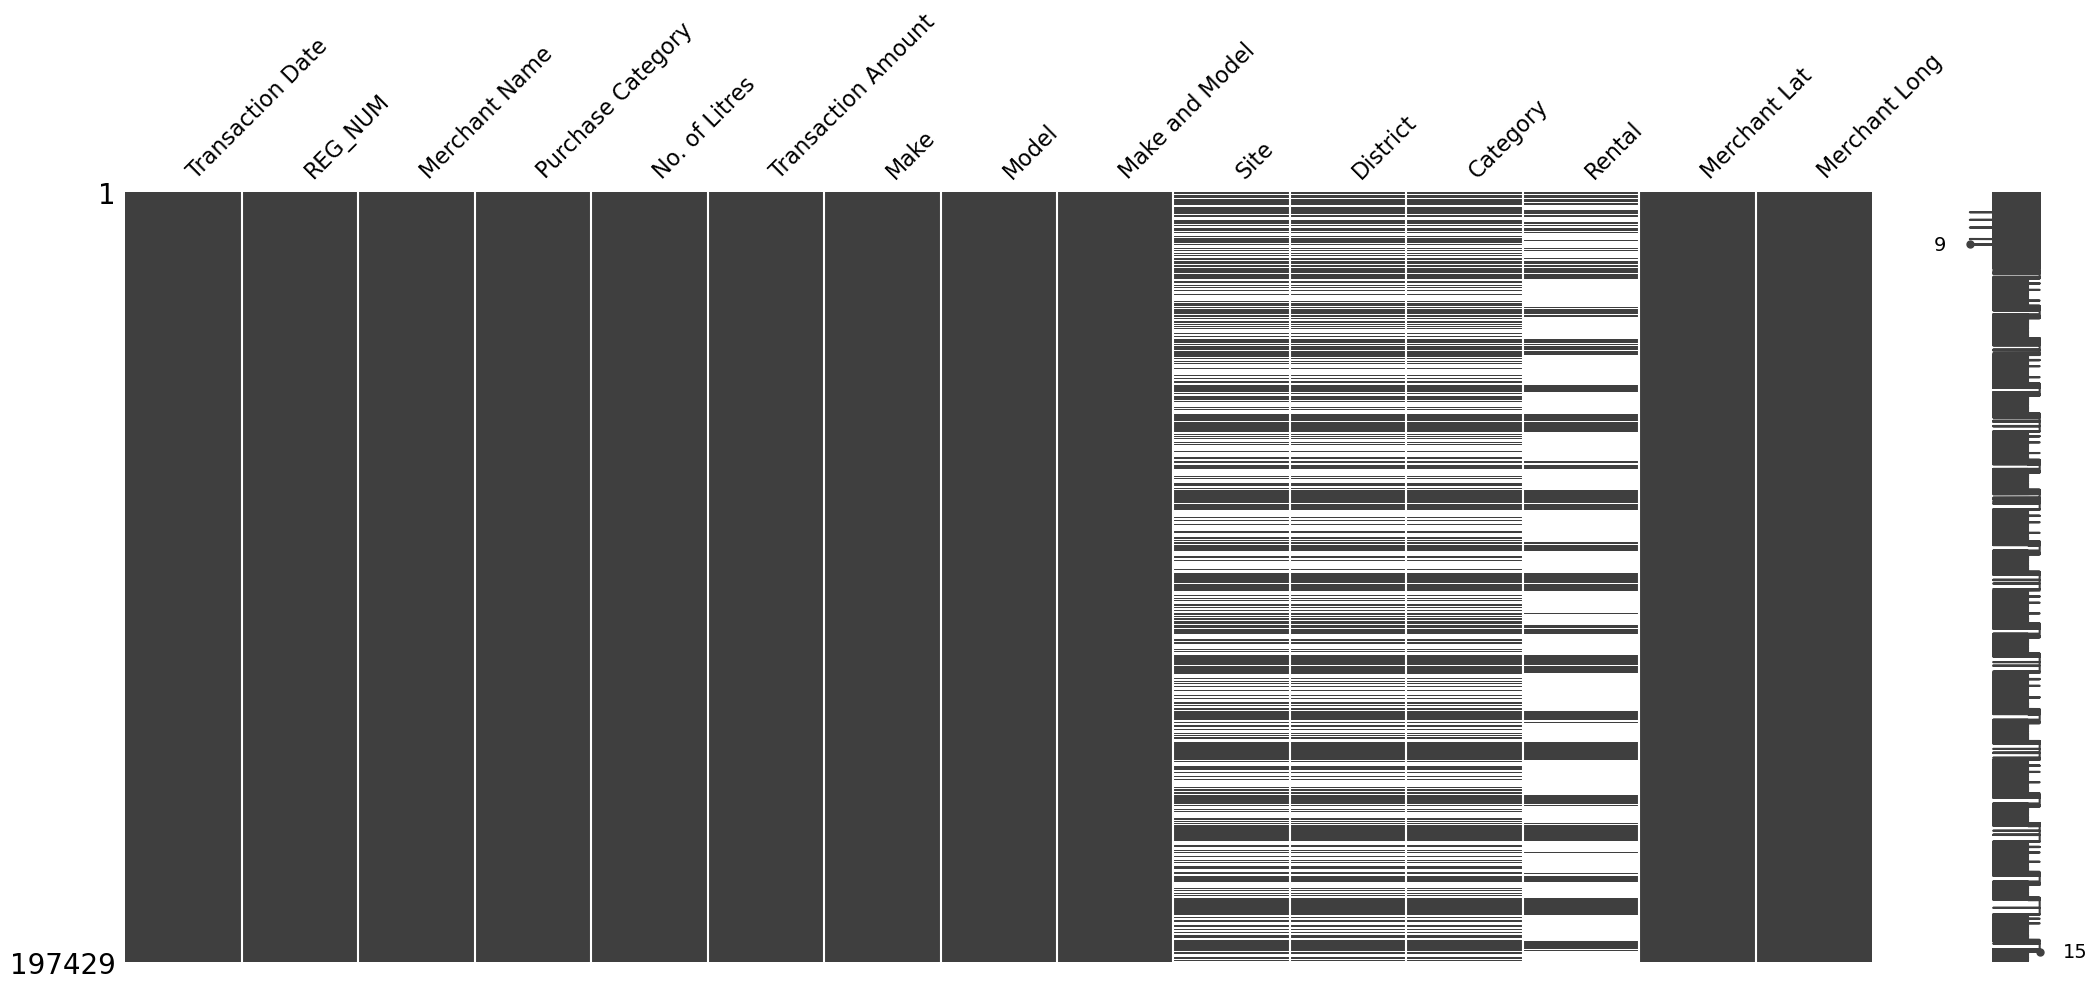

In [231]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import missingno as msno
import matplotlib.pyplot as plt

# Visualizing the missingness pattern
msno.matrix(df_all)
plt.show()

## Category

In [232]:
# Check how many rows have null values in the Category column
df_all['Category'].isnull().sum()

90432

In [233]:
# Display the unique Category values
df_all['Category'].unique()

array(['CATEGORY 8: LDV Ambulance', 'CATEGORY 33: LDV D/cab Response',
       'CATEGORY 29: Bus 20-23 seater',
       'CATEGORY 20: Truck 4 Ton dropside', 'CATEGORY 13: LDV 4x4 D/Cab',
       'CATEGORY 6: LDV 4x2 D/Cab', nan, 'CATEGORY 10: LDV Rescue',
       'CATEGORY 5: LDV 4x2 1 ton ', 'CATEGORY 15: Minibus 14-16 seater',
       'CATEGORY 1: Sedan 1400-1600cc',
       'CATEGORY 18: Ambulances Large p/van',
       'CATEGORY 11: LDV 4x4 1 ton light', 'CATEGORY 7: LDV Mortuary',
       'CATEGORY 46: 14-16 Seater Patient Transport',
       'CATEGORY 32: LDV Heavy Rescue',
       'CATEGORY 38: LDV Mortuary-Hydraulic', 'CATEGORY 9: LDV Clinic',
       'CATEGORY 12: LDV 4x4 1 ton heavy',
       'CATEGORY 17: Ambulances  standard p/van',
       'CATEGORY 3: Hatch 2000 Paramedic',
       'CATEGORY 30: Bus 32-35 seater',
       'CATEGORY 19: Truck 3.5 ton dropside'], dtype=object)

In [234]:
# Save the dataset with imputed values
df_all.to_csv(os.path.join("..", "data", "Final with Merchant Coords and Imputed.csv"), index=False)

In [235]:
df_all.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental',
       'Merchant Lat', 'Merchant Long'],
      dtype='object')

## Site

In [3]:
import pandas as pd
import os

# Load in the dataset
df_all = pd.read_csv(os.path.join("..", "data", "Final with Merchant Coords and Imputed.csv"))

In [4]:
df_all.shape

(197429, 15)

In [5]:
# Check how many unique sites there are
df_all['Site'].nunique()

322

In [6]:
# Convert all sites to upper case
df_all['Site'] = df_all['Site'].str.upper()

In [7]:
# Display the unique sites
df_all['Site'].unique()

array(['LIBODE', 'JANSENVILLE', 'ALIWAL NORTH', '0', 'BUTTERWORTH',
       'MT AYLIFF', 'NTABANKULU', 'EAST LONDON', 'PORT ALFRED',
       'SOMERSET EAST', 'GRAAFF REINET', 'LUSIKISIKI', 'POOL', 'MTHATHA',
       'QUEENSTOWN', 'GREENVILLE HOSPITAL *P', 'DIR: JOE GQABI *P',
       "LILITHA NURSING COL - ST LUCY'S *P", 'SENQU LSA OFFICE ADMIN *P',
       nan, 'HUMANSDORP', 'BURGERSDORP', 'INDWE', 'GRAHAMSTOWN',
       'QUEENSTOWN\\FLEET', '43735', 'FLAGSTAFF', 'KSD', 'STUTTERHEIM',
       'COFIMVABA', 'MZAMBA', 'MT FRERE', 'BIZANA', 'VINCENT', 'CRADOCK',
       'KOMGA', 'ADELAIDE HOSPITAL *P', 'KING WILLIAMS TOWN', 'ALICE',
       'EAST LONDON CAMPUS *P', 'AMAHLATHI LSA OFFICE ADMIN *P',
       'TAYLER BEQUEST (MT FLETCHER) HOSP *P', 'EMPILISWENI HOSPITAL *P',
       'SIPETHU HOSPITAL *P', 'ANDRIES VOSLOO HOSPITAL *P',
       'MALETSWAI LSA OFFICE ADMIN *P', 'MT AYLIFF HOSPITAL *P',
       'FORT ENGLAND PSYCHIATRIC HOSPITAL *P', '43501', 'SIPHETU',
       'STERKSPRUIT', 'KAREEDOUW', 'KIR

In [11]:
df = df_all

# Extract unique site names
unique_names = df['Site'].unique()

# Remove null values
unique_names = unique_names[~pd.isnull(unique_names)]

# Dictionary to hold each name and its similar names
similar_names_dict = {}

# Iterate over each unique name
for name in unique_names:
    # Find similar names
    similar_names = find_similar_names(name, unique_names)
    # Store in the dictionary
    similar_names_dict[name] = similar_names

# Print the results, excluding exact matches
for name, similarities in similar_names_dict.items():
    if similarities:  # Only print if there are non-exact matches
        print(f"{name}: {similarities}")

ALIWAL NORTH: ['ALWAL NORTH']
NTABANKULU: ['TABANKULU']
GRAAFF REINET: ['GRAAF REINET', 'GRAAF-REINET']
BARKLYEAST: ['BARKLY EAST']
LADY GREY HOSPITAL *P: ['GREY HOSPITAL *P']
GRAAF REINET: ['GRAAFF REINET']
BARKLY EAST: ['BARKLYEAST']
FORENSIC BUTTERWORTH *P: ['FORENSIC S BUTTERWORTH *P']
GLEN GREY HOSPITAL *P: ['GREY HOSPITAL *P']
LILITHA NURSING COL - QUEENSTOWN (STERKSPRUIT) *P: ['LILITHA NURSING COL - QUEENSTOWN *P']
LILITHA NURSING COL - QUEENSTOWN *P: ['LILITHA NURSING COL - QUEENSTOWN (STERKSPRUIT) *P']
TABANKULU: ['NTABANKULU']
GREY HOSPITAL *P: ['LADY GREY HOSPITAL *P', 'GLEN GREY HOSPITAL *P']
ALWAL NORTH: ['ALIWAL NORTH']
FORENSIC S BUTTERWORTH *P: ['FORENSIC BUTTERWORTH *P']
GRAAF-REINET: ['GRAAFF REINET']


In [12]:
# Consolidate similar names into a single representative name for each group
names_map = consolidate_names(similar_names_dict)

# Replace names in the DataFrame
df = replace_names(df, names_map, var='Site')

# View the replaced DataFrame
df.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,District,Category,Rental,Merchant Lat,Merchant Long
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,FUEL,43.06,695.45,ISUZU,DMAX 250,ISUZU DMAX 250,LIBODE,OR Tambo,CATEGORY 8: LDV Ambulance,19079.5,-30.632344,28.224885
1,2021-04-01,GGA345EC,SB DELTA,FUEL,31.02,478.17,ISUZU,DMAX 250,ISUZU DMAX 250,JANSENVILLE,Sarah Baartman,CATEGORY 8: LDV Ambulance,19079.5,-32.296840,26.419389
2,2021-04-01,GGA345EC,SB DELTA,FUEL,58.95,908.52,ISUZU,DMAX 250,ISUZU DMAX 250,JANSENVILLE,Sarah Baartman,CATEGORY 8: LDV Ambulance,19079.5,-32.296840,26.419389
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,58.61,963.66,ISUZU,DMAX 250,ISUZU DMAX 250,ALWAL NORTH,Alfred Nzo,CATEGORY 8: LDV Ambulance,19079.5,-30.691447,28.505138
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,60.02,986.76,ISUZU,DMAX 250,ISUZU DMAX 250,ALWAL NORTH,Alfred Nzo,CATEGORY 8: LDV Ambulance,19079.5,-30.691447,28.505138


In [13]:
# Display the number of unique sites
df['Site'].nunique()

282

In [14]:
# Display the unique sites
df['Site'].unique()

array(['LIBODE', 'JANSENVILLE', 'ALWAL NORTH', '0', 'BUTTERWORTH',
       'MT AYLIFF', 'TABANKULU', 'EAST LONDON', 'PORT ALFRED',
       'SOMERSET EAST', 'GRAAF-REINET', 'LUSIKISIKI', 'POOL', 'MTHATHA',
       'QUEENSTOWN', 'GREENVILLE HOSPITAL *P', 'DIR: JOE GQABI *P',
       "LILITHA NURSING COL - ST LUCY'S *P", 'SENQU LSA OFFICE ADMIN *P',
       nan, 'HUMANSDORP', 'BURGERSDORP', 'INDWE', 'GRAHAMSTOWN',
       'QUEENSTOWN\\FLEET', '43735', 'FLAGSTAFF', 'KSD', 'STUTTERHEIM',
       'COFIMVABA', 'MZAMBA', 'MT FRERE', 'BIZANA', 'VINCENT', 'CRADOCK',
       'KOMGA', 'ADELAIDE HOSPITAL *P', 'KING WILLIAMS TOWN', 'ALICE',
       'EAST LONDON CAMPUS *P', 'AMAHLATHI LSA OFFICE ADMIN *P',
       'TAYLER BEQUEST (MT FLETCHER) HOSP *P', 'EMPILISWENI HOSPITAL *P',
       'SIPETHU HOSPITAL *P', 'ANDRIES VOSLOO HOSPITAL *P',
       'MALETSWAI LSA OFFICE ADMIN *P', 'MT AYLIFF HOSPITAL *P',
       'FORT ENGLAND PSYCHIATRIC HOSPITAL *P', '43501', 'SIPHETU',
       'STERKSPRUIT', 'KAREEDOUW', 'KIRKWO

In [15]:
def replace_site_names(df, site_replacements):
    """
    Replace site names in the dataframe based on certain patterns.

    :param df: DataFrame containing the 'Site' column.
    :return: DataFrame with updated 'Site' column.
    """

    # Temporarily fill NaN values with an empty string for comparison
    df['Site'] = df['Site'].fillna('')

    for old_site, new_site in site_replacements.items():
        # Check that the values are not null
        if not pd.isnull(old_site) and not pd.isnull(new_site):
            # Using str.startswith() to match the beginning of the string
            df.loc[df['Site'].str.startswith(old_site), 'Site'] = new_site

    # Revert the empty strings back to NaN
    df['Site'].replace('', pd.NA, inplace=True)

    return df

In [16]:
site_replacements = {
    '0': 'UNKNOWN',
    '43501': 'UNKNOWN',
    'QUEENSTOWN': 'QUEENSTOWN',
}

# Apply the function to replace model names
df = replace_site_names(df, site_replacements)

# Example of the replaced DataFrame
df.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,District,Category,Rental,Merchant Lat,Merchant Long
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,FUEL,43.06,695.45,ISUZU,DMAX 250,ISUZU DMAX 250,LIBODE,OR Tambo,CATEGORY 8: LDV Ambulance,19079.5,-30.632344,28.224885
1,2021-04-01,GGA345EC,SB DELTA,FUEL,31.02,478.17,ISUZU,DMAX 250,ISUZU DMAX 250,JANSENVILLE,Sarah Baartman,CATEGORY 8: LDV Ambulance,19079.5,-32.296840,26.419389
2,2021-04-01,GGA345EC,SB DELTA,FUEL,58.95,908.52,ISUZU,DMAX 250,ISUZU DMAX 250,JANSENVILLE,Sarah Baartman,CATEGORY 8: LDV Ambulance,19079.5,-32.296840,26.419389
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,58.61,963.66,ISUZU,DMAX 250,ISUZU DMAX 250,ALWAL NORTH,Alfred Nzo,CATEGORY 8: LDV Ambulance,19079.5,-30.691447,28.505138
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,60.02,986.76,ISUZU,DMAX 250,ISUZU DMAX 250,ALWAL NORTH,Alfred Nzo,CATEGORY 8: LDV Ambulance,19079.5,-30.691447,28.505138


In [17]:
df.shape

(197429, 15)

## Add the site locations

In [118]:
from geopy.geocoders import GoogleV3
import configparser
import pandas as pd

# Read API key from config file
config = configparser.ConfigParser()
config.read('../config.ini')
api_key = config['DEFAULT']['GOOGLE_API_KEY']

# Create a geocoder object
geolocator = GoogleV3(api_key=api_key)

# Function to get coordinates
def get_coordinates(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
    except Exception as e:
        print(f"Error occurred: {e}")
    return None, None

# Caching the geocoded results
cached_coordinates = {}

# Iterate over unique sites
for site in df['Site'].unique():
    address = f"{site}, Eastern Cape, South Africa"
    if address not in cached_coordinates:
        cached_coordinates[address] = get_coordinates(address)

# Apply cached coordinates to the DataFrame
df['Site Lat'] = df['Site'].map(lambda x: cached_coordinates[f"{x}, Eastern Cape, South Africa"][0])
df['Site Long'] = df['Site'].map(lambda x: cached_coordinates[f"{x}, Eastern Cape, South Africa"][1])

In [119]:
df.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,District,Category,Imputed,Merchant Lat,Merchant Long,Site Lat,Site Long
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,FUEL,43.06,695.45,ISUZU,DMAX 250,ISUZU DMAX 250,LIBODE,OR Tambo,CATEGORY 8: LDV Ambulance,0,-30.632344,28.224885,-31.541836,29.016233
1,2021-04-01,GGA345EC,SB DELTA,FUEL,31.02,478.17,ISUZU,DMAX 250,ISUZU DMAX 250,JANSENVILLE,Sarah Baartman,CATEGORY 8: LDV Ambulance,0,-32.296840,26.419389,-32.943528,24.654919
2,2021-04-01,GGA345EC,SB DELTA,FUEL,58.95,908.52,ISUZU,DMAX 250,ISUZU DMAX 250,JANSENVILLE,Sarah Baartman,CATEGORY 8: LDV Ambulance,0,-32.296840,26.419389,-32.943528,24.654919
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,58.61,963.66,ISUZU,DMAX 250,ISUZU DMAX 250,ALWAL NORTH,Alfred Nzo,CATEGORY 8: LDV Ambulance,0,-30.691447,28.505138,-30.695841,26.708941
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,60.02,986.76,ISUZU,DMAX 250,ISUZU DMAX 250,ALWAL NORTH,Alfred Nzo,CATEGORY 8: LDV Ambulance,0,-30.691447,28.505138,-30.695841,26.708941


In [21]:
# Save the transformed data to a csv file in the data folder
df.to_csv(os.path.join("..", "data", "Final Imputed with Merchant and Site Coords.csv"), index=False)

## Add the fuel types for each make and model

In [22]:
# View all unique makes and models
df['Make and Model'].unique()

array(['ISUZU DMAX 250', 'VOLKSWAGEN CRAFTER 50', 'TOYOTA HINO 300',
       'TOYOTA HILUX', 'TOYOTA QUANTUM', 'VOLKSWAGEN GOLF',
       'VOLKSWAGEN POLO', 'VOLKSWAGEN AMAROK', 'VOLKSWAGEN CRAFTER 35',
       'NISSAN NP 300', 'TOYOTA COROLLA', 'NISSAN NV 350', 'FORD FOCUS',
       'FORD AMBIENTE', 'FORD RANGER', 'HYUNDAI FLUID', 'HYUNDAI ACCENT',
       'ISUZU KB 200', 'ISUZU KB 250', 'ISUZU KB 300',
       'MERCEDES SPRINTER', 'NISSAN PATROL', 'CHEVROLET AVEO',
       'NISSAN HARDBODY', 'AUDI Q7', 'NISSAN 1400 LDV',
       'TOYOTA LANDCRUISER', 'VOLKSWAGEN JETTA', 'TOYOTA PRADO',
       'TOYOTA FORTUNER', 'TOYOTA PANELVAN', 'MERCEDES GLE500', 'BMW X5',
       'FORD LASER', 'NISSAN ALMERA', 'BMW X4', 'VOLKSWAGEN CITI',
       'VOLKSWAGEN CADDY', 'NISSAN NP 200', 'TOYOTA ETIOS', 'FORD IKON',
       'OPEL ASTRA', 'NISSAN TIIDA', 'BMW R1250RT', 'MERCEDES ML 250',
       'ISUZU DMAX 300', 'VOLKSWAGEN TRANSPORTER', 'FORD BANTAM',
       'FIAT PALIO', 'OPEL CORSA', 'NISSAN INTERSTAR', 'FORD F

In [23]:
# Remove toyota hino
df = df[df['Make and Model'] != 'TOYOTA HINO 300']

In [24]:
# Create a new column for the fuel type
df['Fuel Type'] = "DIESEL"

# Create a list to store the make and models of the petrol vehicles
petrol_vehicles = ['VOLKSWAGEN GOLF', 'VOLKSWAGEN POLO', 'FORD FOCUS', 
                   'TOYOTA COROLLA', 'HYUNDAI FLUID', 'HYUNDAI ACCENT', 'NISSAN 1400 LDV', 
                   'VOLKSWAGEN JETTA', 'MERCEDES GLE500', 'FORD LASER', 'NISSAN ALMERA',
                   'VOLKSWAGEN CITI', 'VOLKSWAGEN CADDY', 'TOYOTA ETIOS', 'FORD IKON',
                   'OPEL ASTRA', 'NISSAN TIIDA', 'BMW R1250RT', 'FORD BANTAM', 'FIAT PALIO',
                   'OPEL CORSA', 'FORD FIESTA', 'TOYOTA YARIS', 'TATA INDICA', 'ISUZU KB 160',
                   'AUDI Q5', 'TOYOTA AVANZA', 'VOLKSWAGEN TIGUAN', 'TATA INDIGO', 'FORD FIGO']

# Change the fuel type to petrol for the petrol vehicles
df.loc[df['Make and Model'].isin(petrol_vehicles), 'Fuel Type'] = "PETROL"

/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_12007/554486499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fuel Type'] = "DIESEL"


In [25]:
# Check the value counts for the fuel type
df['Fuel Type'].value_counts()

Fuel Type
DIESEL    140887
PETROL     56289
Name: count, dtype: int64

In [26]:
df.shape

(197176, 18)

In [27]:
# Save the data frame
df.to_csv(os.path.join("..", "data", "Final Imputed with Merchant and Site Coords and Fuel Type.csv"), index=False)

## Add the actual fuel prices

In [28]:
# Read in the dataset
df = pd.read_csv(os.path.join("..", "data", "Final Imputed with Merchant and Site Coords and Fuel Type.csv"))

# Convert the transaction date to datetime
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])

In [29]:
file_path_fuel = os.path.join("..", "data", "FuelPricesWithDates.csv")

# Load the dataset
fuel_data = pd.read_csv(file_path_fuel, delimiter=';').transpose()


# Resetting the index to make the first row as header
fuel_data.reset_index(inplace=True)
new_header = fuel_data.iloc[0] # grab the first row for the header
fuel_data = fuel_data[1:] # take the data less the header row
fuel_data.columns = new_header # set the header row as the dataframe header


# Rename the columns
fuel_data.rename(columns={'95 LRP (c/l)': 'Petrol',
                          'Diesel 0.05% (c/l) ': 'Diesel',
                          '95 ULP (c/l) *': 'Petrol Inland',
                          'Diesel 0.05% (c/l) **': 'Diesel Inland'}, inplace=True)

# Change the Date column to datetime
fuel_data['Date'] = pd.to_datetime(fuel_data['Date'])

# Displaying the first few rows of the transposed dataset
fuel_data.head()

,Date,Petrol,Diesel,Petrol Inland,Diesel Inland
1,2020-12-02,1376,"1185,12",1446,"1245,42"
2,2021-01-06,1416,"1240,12",1486,"1300,42"
3,2021-02-03,1497,"1298,12",1567,"1358,42"
4,2021-03-03,1562,"1352,12",1632,"1412,42"
5,2021-04-07,1660,"1416,12",1732,"1477,62"


In [30]:
# Swap out all ',' for '.' in the 'Petrol' and 'Diesel' column
fuel_data['Petrol'] = fuel_data['Petrol'].str.replace(',', '.').str.strip()
fuel_data['Diesel'] = fuel_data['Diesel'].str.replace(',', '.').str.strip()
fuel_data['Petrol Inland'] = fuel_data['Petrol Inland'].str.replace(',', '.').str.strip()
fuel_data['Diesel Inland'] = fuel_data['Diesel Inland'].str.replace(',', '.').str.strip()

# Convert the columns to the correct format
fuel_data['Date'] = pd.to_datetime(fuel_data['Date'])
fuel_data['Petrol'] = pd.to_numeric(fuel_data['Petrol']) / 100
fuel_data['Diesel'] = pd.to_numeric(fuel_data['Diesel']) / 100
fuel_data['Petrol Inland'] = pd.to_numeric(fuel_data['Petrol Inland']) / 100
fuel_data['Diesel Inland'] = pd.to_numeric(fuel_data['Diesel Inland']) / 100

In [141]:
fuel_data

,Date,Petrol,Diesel,Petrol Inland,Diesel Inland
1,2020-12-02,13.76,11.8512,14.46,12.4542
2,2021-01-06,14.16,12.4012,14.86,13.0042
3,2021-02-03,14.97,12.9812,15.67,13.5842
4,2021-03-03,15.62,13.5212,16.32,14.1242
5,2021-04-07,16.60,14.1612,17.32,14.7762
6,2021-05-05,16.51,13.8512,17.23,14.4662
7,2021-06-02,16.41,14.0512,17.13,14.6662
8,2021-07-07,16.67,14.4712,17.39,15.0862
9,2021-08-04,17.58,15.0270,18.30,15.6420
10,2021-09-01,17.62,14.8748,18.34,15.4898


In [31]:
def get_fuel_price(transaction_date, fuel_type, fuel_prices_df, inland=False):
    # Filter the prices up to the transaction date
    relevant_prices = fuel_prices_df[fuel_prices_df['Date'] <= transaction_date].iloc[-1]
    
    if inland:
        if fuel_type == 'PETROL':
            return relevant_prices['Petrol Inland']
        else:
            return relevant_prices['Diesel Inland']

    # Select the appropriate fuel price based on vehicle category
    if fuel_type == 'PETROL':
        return relevant_prices['Petrol']
    else:
        return relevant_prices['Diesel']

In [32]:
df['Actual Fuel Price'] = df.apply(
    lambda row: get_fuel_price(row['Transaction Date'], row['Fuel Type'], fuel_data), 
    axis=1
)

df['Actual Fuel Price Inland'] = df.apply(
    lambda row: get_fuel_price(row['Transaction Date'], row['Fuel Type'], fuel_data, inland=True), 
    axis=1
)

df.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,District,Category,Rental,Merchant Lat,Merchant Long,Site Lat,Site Long,Fuel Type,Actual Fuel Price,Actual Fuel Price Inland
0,2021-04-01,GGA344EC,ULUNDI FILLING STATION,FUEL,43.06,695.45,ISUZU,DMAX 250,ISUZU DMAX 250,LIBODE,OR Tambo,CATEGORY 8: LDV Ambulance,19079.5,-30.632344,28.224885,-31.541836,29.016233,DIESEL,13.5212,14.1242
1,2021-04-01,GGA345EC,SB DELTA,FUEL,31.02,478.17,ISUZU,DMAX 250,ISUZU DMAX 250,JANSENVILLE,Sarah Baartman,CATEGORY 8: LDV Ambulance,19079.5,-32.296840,26.419389,-32.943528,24.654919,DIESEL,13.5212,14.1242
2,2021-04-01,GGA345EC,SB DELTA,FUEL,58.95,908.52,ISUZU,DMAX 250,ISUZU DMAX 250,JANSENVILLE,Sarah Baartman,CATEGORY 8: LDV Ambulance,19079.5,-32.296840,26.419389,-32.943528,24.654919,DIESEL,13.5212,14.1242
3,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,58.61,963.66,ISUZU,DMAX 250,ISUZU DMAX 250,ALWAL NORTH,Alfred Nzo,CATEGORY 8: LDV Ambulance,19079.5,-30.691447,28.505138,-30.695841,26.708941,DIESEL,13.5212,14.1242
4,2021-04-01,GGA346EC,MOUNT FLETCHER MOTORS EASTERN CAPE,FUEL,60.02,986.76,ISUZU,DMAX 250,ISUZU DMAX 250,ALWAL NORTH,Alfred Nzo,CATEGORY 8: LDV Ambulance,19079.5,-30.691447,28.505138,-30.695841,26.708941,DIESEL,13.5212,14.1242


In [33]:
# Create the estimated price per litre variable
df['Estimated Price Per Litre'] = df['Transaction Amount'] / df['No. of Litres']

In [35]:
# Display the Estimated ppl and the Actual ppl and inland ppl
df[['Transaction Date', 'Fuel Type', 'Make and Model','Estimated Price Per Litre', 'Actual Fuel Price', 'Actual Fuel Price Inland']].sample(15)

,Transaction Date,Fuel Type,Make and Model,Estimated Price Per Litre,Actual Fuel Price,Actual Fuel Price Inland
124152,2021-10-13,DIESEL,FORD RANGER,17.161747,15.1028,15.7178
161688,2021-12-01,DIESEL,FORD RANGER,19.462822,17.3098,17.9248
165078,2021-12-08,DIESEL,VOLKSWAGEN CRAFTER 50,19.840038,17.3098,17.9248
11143,2021-04-20,DIESEL,FORD RANGER,16.200407,14.1612,14.7762
183942,2022-01-02,DIESEL,VOLKSWAGEN CRAFTER 50,19.150508,17.3098,17.9248
196979,2022-01-11,DIESEL,TOYOTA HILUX,19.418902,16.6318,17.2468
27164,2021-05-13,PETROL,VOLKSWAGEN POLO,16.989449,16.5100,17.2300
26001,2021-05-12,DIESEL,TOYOTA HILUX,16.329998,13.8512,14.4662
173811,2021-12-20,DIESEL,FORD RANGER,18.930115,17.3098,17.9248
41991,2021-06-22,PETROL,TOYOTA COROLLA,17.260025,16.4100,17.1300


In [36]:
# Save the data frame
df.to_csv(os.path.join("..", "data", "Final Imputed with Coords, Fuel Type and Prices.csv"), index=False)

In [37]:
df.shape

(197176, 21)

## Create a fuel efficiency dataset based on tracker data (too many issues)

In [38]:
# Read in the dataset
df = pd.read_csv(os.path.join("..", "data", "Final Imputed with Coords, Fuel Type and Prices.csv"))

In [39]:
# Read in the tracker data
file_path = os.path.join("..", "data", "OdoValuesTracker.csv")

# Load the dataset
tracker_data = pd.read_csv(file_path)

In [40]:
tracker_data.head()

,Reg,Date,Odo,CastedOdo
0,GGF356EC,2021-04-01,122 148,122148.0
1,GGF360EC,2021-04-01,25 600,25600.0
2,GGF364EC,2021-04-01,14 135,14135.0
3,GGF367EC,2021-04-01,64 839,64839.0
4,GGF369EC,2021-04-01,86 982,86982.0


In [41]:
# Drop the Odo column and rename the CastedOdo to be Odo
tracker_data = tracker_data.drop(columns=['Odo']).rename(columns={'CastedOdo': 'Odo'})

In [42]:
df.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental',
       'Merchant Lat', 'Merchant Long', 'Site Lat', 'Site Long', 'Fuel Type',
       'Actual Fuel Price', 'Actual Fuel Price Inland',
       'Estimated Price Per Litre'],
      dtype='object')

In [43]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])

# Group by 'REG_NUM' to get sum of 'No. of Litres' and date range
litres_data = df.groupby('REG_NUM').agg({'No. of Litres': 'sum',
                                           'Transaction Date': ['min', 'max'],
                                           'Make and Model': 'first',
                                           'District': 'first',
                                           'Category': 'first'}
                                           ).reset_index()

# Flatten the MultiIndex columns
litres_data.columns = ['REG_NUM', 'Total Litres', 'Min Date', 'Max Date', 'Make and Model', 'District', 'Category']

In [44]:
litres_data.head()

,REG_NUM,Total Litres,Min Date,Max Date,Make and Model,District,Category
0,GGA001EC,2964.03,2021-04-04,2021-10-14,FORD RANGER,OR Tambo,CATEGORY 18: Ambulances Large p/van
1,GGA002EC,4219.71,2021-04-08,2021-12-07,FORD RANGER,None,None
2,GGA005EC,5167.84,2021-04-01,2021-11-08,FORD RANGER,OR Tambo,CATEGORY 8: LDV Ambulance
3,GGA007EC,135.84,2021-09-20,2021-11-25,FORD RANGER,None,None
4,GGA008EC,2526.30,2021-04-01,2022-01-27,FORD RANGER,Amathole,CATEGORY 8: LDV Ambulance


In [45]:
import pandas as pd

# Convert 'Date' to datetime in both datasets
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
tracker_data['Date'] = pd.to_datetime(tracker_data['Date'])

# Ensure consistent column names for vehicle registration
df.rename(columns={'REG_NUM': 'Reg'}, inplace=True)

# Calculate the min and max dates for each vehicle in both datasets
odo_range = tracker_data.groupby('Reg')['Date'].agg(['min', 'max']).reset_index()
litres_range = df.groupby('Reg')['Transaction Date'].agg(['min', 'max']).reset_index()

# Merge to find overlapping dates
overlap_data = pd.merge(odo_range, litres_range, on='Reg', how='inner', suffixes=('_odo', '_litres'))

# Determine the largest overlapping range
overlap_data['Overlap_Start'] = overlap_data[['min_odo', 'min_litres']].max(axis=1)
overlap_data['Overlap_End'] = overlap_data[['max_odo', 'max_litres']].min(axis=1)

# Filter out non-overlapping entries
overlap_data = overlap_data[overlap_data['Overlap_Start'] <= overlap_data['Overlap_End']]

# Initialize columns for total calculations
overlap_data['Total_Km'] = 0
overlap_data['Total_Litres'] = 0

# Calculate total Km and Litres for each vehicle
for index, row in overlap_data.iterrows():
    reg = row['Reg']
    start, end = row['Overlap_Start'], row['Overlap_End']

    # Filter for each vehicle within the overlapping dates
    odo_filtered = tracker_data[(tracker_data['Reg'] == reg) & (tracker_data['Date'] >= start) & (tracker_data['Date'] <= end)]
    litres_filtered = df[(df['Reg'] == reg) & (df['Transaction Date'] >= start) & (df['Transaction Date'] <= end)]

    # Calculate total kilometers and liters
    if not odo_filtered.empty and not litres_filtered.empty:
        total_km = odo_filtered['Odo'].iloc[-1] - odo_filtered['Odo'].iloc[0]
        total_litres = litres_filtered['No. of Litres'].sum()

        # Update the overlap_data DataFrame
        overlap_data.at[index, 'Total_Km'] = total_km
        overlap_data.at[index, 'Total_Litres'] = total_litres

# Calculate KMPL
overlap_data['KMPL'] = overlap_data['Total_Km'] / overlap_data['Total_Litres']

# Final dataset with overlapping date ranges and KMPL
final_data = overlap_data[['Reg', 'Overlap_Start', 'Overlap_End', 'Total_Km', 'Total_Litres', 'KMPL']].dropna()

final_data.head()


,Reg,Overlap_Start,Overlap_End,Total_Km,Total_Litres,KMPL
0,GGF355EC,2021-07-01,2021-12-03,8968,748.52,11.980976
1,GGF356EC,2021-04-01,2022-01-25,18420,1681.21,10.956395
2,GGF358EC,2021-07-01,2021-12-31,11320,1145.65,9.880854
3,GGF363EC,2021-07-01,2021-12-31,8571,822.54,10.420162
4,GGF364EC,2021-04-07,2021-06-30,8016,754.15,10.629185


In [47]:
final_data.shape

(1042, 6)

In [48]:
# Save the final data
final_data.to_csv(os.path.join("..", "data", "Final KMPL dataset.csv"), index=False)

## Aggregated the dataset to the vehicle level and add KMPL data

In [66]:
# Read in the transaction dataset
df = pd.read_csv(os.path.join("..", "data", "Final Imputed with Coords, Fuel Type and Prices.csv"))

In [67]:
# Check the columns
df.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental',
       'Merchant Lat', 'Merchant Long', 'Site Lat', 'Site Long', 'Fuel Type',
       'Actual Fuel Price', 'Actual Fuel Price Inland',
       'Estimated Price Per Litre'],
      dtype='object')

In [69]:
# Aggregate the dataset by REG_NUM
df_agg = df.groupby('REG_NUM').agg({'Transaction Amount': ['sum', 'mean'],
                                    'No. of Litres': ['sum', 'mean'],
                                    'Model': 'first',
                                    'Make and Model': 'first',
                                    'District': 'first',
                                    'Site': 'first',
                                    'Category': 'first',
                                    'Site Lat': 'first',
                                    'Site Long': 'first',
                                    'Fuel Type': 'first',
                                    'Rental': 'first',
                                    'Actual Fuel Price': 'mean',
                                    'Actual Fuel Price Inland': 'mean',
                                    'Estimated Price Per Litre': 'mean',}
                                    ).reset_index()

In [70]:
df_agg.head()

REG_NUM Transaction Amount              No. of Litres              Model  \
                           sum         mean           sum       mean   first   
0  GGA001EC           50839.76   847.329333       2964.03  49.400500  RANGER   
1  GGA002EC           74634.78   761.579388       4219.71  43.058265  RANGER   
2  GGA005EC           89670.40   896.704000       5167.84  51.678400  RANGER   
3  GGA007EC            2400.00  1200.000000        135.84  67.920000  RANGER   
4  GGA008EC           44332.00   836.452830       2526.30  47.666038  RANGER   

  Make and Model  District         Site                             Category  \
           first     first        first                                first   
0    FORD RANGER  OR Tambo       UMTATA  CATEGORY 18: Ambulances Large p/van   
1    FORD RANGER      None         None                                 None   
2    FORD RANGER  OR Tambo        TSOLO            CATEGORY 8: LDV Ambulance   
3    FORD RANGER      None         None                                 None   
4    FORD RANGER  Amathole  BUTTERWORTH            CATEGORY 8: LDV Ambulance   

    Site Lat  Site Long Fuel Type    Rental Actual Fuel Price  \
       first      first     first     first              mean   
0 -31.594050  28.756873    DIESEL  23731.68         14.710303   
1        NaN        NaN    DIESEL       NaN         15.228486   
2 -31.319447  28.754782    DIESEL   9009.78         14.952516   
3        NaN        NaN    DIESEL       NaN         15.729800   
4 -32.332350  28.144626    DIESEL   9009.78         15.786200   

  Actual Fuel Price Inland Estimated Price Per Litre  
                      mean                      mean  
0                15.324903                 17.148712  
1                15.843486                 17.697350  
2                15.566796                 17.338017  
3                16.344800                 17.576323  
4                16.400974                 17.554233

In [71]:
# Rental value counts with null values
df_agg['Rental'].value_counts(dropna=False)

first   
NaN         3529
25217.52     194
19079.50     122
17947.95     112
9009.78       78
16151.26      77
12477.10      38
8030.90       26
8890.68       17
9367.55       14
9868.15       10
9196.75        9
17905.58       7
8173.60        6
4997.78        4
11713.58       4
7025.77        4
13168.75       3
5659.98        2
8328.68        1
23731.68       1
26752.22       1
11552.73       1
Name: count, dtype: int64

In [72]:
# Flatten MultiIndex columns in df_agg
df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

# Rename the 'REG_NUM_' column to 'Reg' for consistency
df_agg.rename(columns={'REG_NUM_': 'Reg'}, inplace=True)

df_agg.head()

,Reg,Transaction Amount_sum,Transaction Amount_mean,No. of Litres_sum,No. of Litres_mean,Model_first,Make and Model_first,District_first,Site_first,Category_first,Site Lat_first,Site Long_first,Fuel Type_first,Rental_first,Actual Fuel Price_mean,Actual Fuel Price Inland_mean,Estimated Price Per Litre_mean
0,GGA001EC,50839.76,847.329333,2964.03,49.400500,RANGER,FORD RANGER,OR Tambo,UMTATA,CATEGORY 18: Ambulances Large p/van,-31.594050,28.756873,DIESEL,23731.68,14.710303,15.324903,17.148712
1,GGA002EC,74634.78,761.579388,4219.71,43.058265,RANGER,FORD RANGER,None,None,None,NaN,NaN,DIESEL,NaN,15.228486,15.843486,17.697350
2,GGA005EC,89670.40,896.704000,5167.84,51.678400,RANGER,FORD RANGER,OR Tambo,TSOLO,CATEGORY 8: LDV Ambulance,-31.319447,28.754782,DIESEL,9009.78,14.952516,15.566796,17.338017
3,GGA007EC,2400.00,1200.000000,135.84,67.920000,RANGER,FORD RANGER,None,None,None,NaN,NaN,DIESEL,NaN,15.729800,16.344800,17.576323
4,GGA008EC,44332.00,836.452830,2526.30,47.666038,RANGER,FORD RANGER,Amathole,BUTTERWORTH,CATEGORY 8: LDV Ambulance,-32.332350,28.144626,DIESEL,9009.78,15.786200,16.400974,17.554233


In [73]:
# Join the aggregated dataset with the final dataset
merged = pd.merge(df_agg, final_data, how='left', on='Reg')

# Now you can work with the merged DataFrame
merged.head()

,Reg,Transaction Amount_sum,Transaction Amount_mean,No. of Litres_sum,No. of Litres_mean,Model_first,Make and Model_first,District_first,Site_first,Category_first,...,Fuel Type_first,Rental_first,Actual Fuel Price_mean,Actual Fuel Price Inland_mean,Estimated Price Per Litre_mean,Overlap_Start,Overlap_End,Total_Km,Total_Litres,KMPL
0,GGA001EC,50839.76,847.329333,2964.03,49.400500,RANGER,FORD RANGER,OR Tambo,UMTATA,CATEGORY 18: Ambulances Large p/van,...,DIESEL,23731.68,14.710303,15.324903,17.148712,NaT,NaT,NaN,NaN,NaN
1,GGA002EC,74634.78,761.579388,4219.71,43.058265,RANGER,FORD RANGER,None,None,None,...,DIESEL,NaN,15.228486,15.843486,17.697350,NaT,NaT,NaN,NaN,NaN
2,GGA005EC,89670.40,896.704000,5167.84,51.678400,RANGER,FORD RANGER,OR Tambo,TSOLO,CATEGORY 8: LDV Ambulance,...,DIESEL,9009.78,14.952516,15.566796,17.338017,NaT,NaT,NaN,NaN,NaN
3,GGA007EC,2400.00,1200.000000,135.84,67.920000,RANGER,FORD RANGER,None,None,None,...,DIESEL,NaN,15.729800,16.344800,17.576323,NaT,NaT,NaN,NaN,NaN
4,GGA008EC,44332.00,836.452830,2526.30,47.666038,RANGER,FORD RANGER,Amathole,BUTTERWORTH,CATEGORY 8: LDV Ambulance,...,DIESEL,9009.78,15.786200,16.400974,17.554233,NaT,NaT,NaN,NaN,NaN


In [74]:
# Check how many rows have null values in the KMPL column
merged['KMPL'].isnull().sum()

3218

In [76]:
# Check how many rows are not null in the KMPL column
merged['KMPL'].notnull().sum()

1042

In [61]:
merged.head()

,Reg,Transaction Amount_sum,Transaction Amount_mean,No. of Litres_sum,No. of Litres_mean,Make and Model_first,District_first,Site_first,Category_first,Site Lat_first,...,Rental_first,Actual Fuel Price_mean,Actual Fuel Price Inland_mean,Estimated Price Per Litre_mean,Overlap_Start,Overlap_End,Total_Km,Total_Litres,KMPL,Imputed
0,GGA001EC,50839.76,847.329333,2964.03,49.400500,FORD RANGER,OR Tambo,UMTATA,CATEGORY 18: Ambulances Large p/van,-31.594050,...,23731.68,14.710303,15.324903,17.148712,NaT,NaT,NaN,NaN,NaN,1
1,GGA002EC,74634.78,761.579388,4219.71,43.058265,FORD RANGER,None,None,None,NaN,...,NaN,15.228486,15.843486,17.697350,NaT,NaT,NaN,NaN,NaN,1
2,GGA005EC,89670.40,896.704000,5167.84,51.678400,FORD RANGER,OR Tambo,TSOLO,CATEGORY 8: LDV Ambulance,-31.319447,...,9009.78,14.952516,15.566796,17.338017,NaT,NaT,NaN,NaN,NaN,1
3,GGA007EC,2400.00,1200.000000,135.84,67.920000,FORD RANGER,None,None,None,NaN,...,NaN,15.729800,16.344800,17.576323,NaT,NaT,NaN,NaN,NaN,1
4,GGA008EC,44332.00,836.452830,2526.30,47.666038,FORD RANGER,Amathole,BUTTERWORTH,CATEGORY 8: LDV Ambulance,-32.332350,...,9009.78,15.786200,16.400974,17.554233,NaT,NaT,NaN,NaN,NaN,1


In [75]:
# Remove the Overlap_Start, Overlap_End columns
merged = merged.drop(columns=['Overlap_Start', 'Overlap_End'])

In [77]:
merged.columns

Index(['Reg', 'Transaction Amount_sum', 'Transaction Amount_mean',
       'No. of Litres_sum', 'No. of Litres_mean', 'Model_first',
       'Make and Model_first', 'District_first', 'Site_first',
       'Category_first', 'Site Lat_first', 'Site Long_first',
       'Fuel Type_first', 'Rental_first', 'Actual Fuel Price_mean',
       'Actual Fuel Price Inland_mean', 'Estimated Price Per Litre_mean',
       'Total_Km', 'Total_Litres', 'KMPL'],
      dtype='object')

In [113]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# import pandas as pd
# from sklearn.preprocessing import OrdinalEncoder


# cols_for_imputation = ['KMPL', 'District_first', 'Site_first', 'Category_first', 'Transaction Amount_sum', 'Transaction Amount_mean',
#        'No. of Litres_sum', 'No. of Litres_mean', 'Make and Model_first',]

# # Extract the relevant part of the DataFrame for imputation
# df_for_imputation = merged[cols_for_imputation].copy()

# # Identify categorical columns for encoding
# categorical_cols = ['District_first', 'Site_first', 'Category_first', 'Make and Model_first']

# # Apply Ordinal Encoding to categorical columns
# encoder = OrdinalEncoder()
# df_for_imputation[categorical_cols] = encoder.fit_transform(df_for_imputation[categorical_cols])

# # Create an instance of the IterativeImputer class
# imputer = IterativeImputer(max_iter=100, random_state=1)

# # Fit the imputer on the DataFrame
# imputer.fit(df_for_imputation)

# # Transform the DataFrame (impute the missing values)
# df_imputed = imputer.transform(df_for_imputation)

# # Convert the imputed numpy array back to a pandas DataFrame
# df_imputed = pd.DataFrame(df_imputed, columns=cols_for_imputation)

# # Inverse transform the encoded categorical columns back to original values
# df_imputed[categorical_cols] = encoder.inverse_transform(df_imputed[categorical_cols])

# merged[['KMPL']] = df_imputed[['KMPL']]

# # Check the first few rows of the DataFrame after imputation
# merged.head()

,Reg,Transaction Amount_sum,Transaction Amount_mean,No. of Litres_sum,No. of Litres_mean,Make and Model_first,District_first,Site_first,Category_first,Site Lat_first,Site Long_first,Fuel Type_first,Actual Fuel Price_mean,Actual Fuel Price Inland_mean,Estimated Price Per Litre_mean,Total_Km,Total_Litres,KMPL,Imputed
0,GGA001EC,50839.76,847.329333,2964.03,49.400500,FORD RANGER,OR Tambo,UMTATA,CATEGORY 18: Ambulances Large p/van,-31.594050,28.756873,DIESEL,14.710303,15.324903,17.148712,NaN,NaN,9.492583,1
1,GGA002EC,74634.78,761.579388,4219.71,43.058265,FORD RANGER,EMS College,KSD,CATEGORY 5: LDV 4x2 1 ton,-31.707399,28.579798,DIESEL,15.228486,15.843486,17.697350,NaN,NaN,8.772191,1
2,GGA005EC,89670.40,896.704000,5167.84,51.678400,FORD RANGER,OR Tambo,TSOLO,CATEGORY 8: LDV Ambulance,-31.319447,28.754782,DIESEL,14.952516,15.566796,17.338017,NaN,NaN,6.841864,1
3,GGA007EC,2400.00,1200.000000,135.84,67.920000,FORD RANGER,Head Office,INDWE,CATEGORY 5: LDV 4x2 1 ton,-31.477137,27.351662,DIESEL,15.729800,16.344800,17.576323,NaN,NaN,7.661285,1
4,GGA008EC,44332.00,836.452830,2526.30,47.666038,FORD RANGER,Amathole,BUTTERWORTH,CATEGORY 8: LDV Ambulance,-32.332350,28.144626,DIESEL,15.786200,16.400974,17.554233,NaN,NaN,8.514807,1


In [78]:
# Save the dataset with imputed values
merged.to_csv(os.path.join("..", "data", "Final aggregated with KMPL and Imputed.csv"), index=False)

In [79]:
# Check how many KMPL values are null
merged['KMPL'].isnull().sum()

3218